<a href="https://colab.research.google.com/github/Zuzed22/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes---Parte-2/blob/main/TelecomX_LATAM_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TelecomX - Parte 2: Predicción de Churn con Machine Learning

## 🎯 Misión

Tu nueva misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

## 🧠 Objetivos del Desafío

- Preparar los datos para el modelado (tratamiento, codificación, normalización).

- Realizar análisis de correlación y selección de variables.

- Entrenar dos o más modelos de clasificación.

- Evaluar el rendimiento de los modelos con métricas.

- Interpretar los resultados, incluyendo la importancia de las variables.

- Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

In [1]:
# Importación de librerías necesarias
print("Importando librerías para Machine Learning...")

try:
    import pandas as pd
    import numpy as np
    import json
    import warnings
    warnings.filterwarnings('ignore')
    print("Pandas, NumPy: OK")
except ImportError as e:
    print(f"Error importando librerías básicas: {e}")

# Visualización
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("Matplotlib, Seaborn: OK")
except ImportError as e:
    print(f"Error: {e}")

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    print("Plotly: OK")
except ImportError as e:
    print(f"Plotly no disponible: {e}")
    print("Instala con: pip install plotly")

# Machine Learning
try:
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report, roc_auc_score, roc_curve
    )
    from sklearn.utils.class_weight import compute_class_weight
    print("Scikit-learn: OK")
except ImportError as e:
    print(f"Error importando sklearn: {e}")

# Balanceo de clases (opcional)
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
    print("SMOTE (imbalanced-learn): OK")
except ImportError:
    smote_available = False
    print("SMOTE no disponible - se usarán class_weights")

# Configuración
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("\n ¡Librerías importadas exitosamente!")
print("Listo para entrenar modelos de Machine Learning")

Importando librerías para Machine Learning...
Pandas, NumPy: OK
Matplotlib, Seaborn: OK
Plotly: OK
Scikit-learn: OK
SMOTE (imbalanced-learn): OK

 ¡Librerías importadas exitosamente!
Listo para entrenar modelos de Machine Learning


## 🛠️ Preparación de los Datos

Se utiliza el mismo archivo JSON de la Parte 1 del desafío Telecom X. Vamos a proceder a preparar esos mismos datos con solo las columnas relevantes, ya con datos corregidos y estandarizados para Machine Learning.

In [2]:
# Funciones de utilidad para preparación de datos
def safe_float_conversion(value, default=0.0):
    """Convierte un valor a float de forma segura, manejando casos especiales."""
    try:
        if isinstance(value, str):
            value = value.strip()
            if value == '' or value == ' ':
                return default
        return float(value)
    except (ValueError, TypeError):
        return default

def flatten_customer_data(customer_record):
    """Aplana la estructura JSON anidada del dataset de TelecomX"""
    flat_record = {}

    # Información básica
    flat_record['customerID'] = customer_record['customerID']
    flat_record['Churn'] = customer_record['Churn']

    # Información del cliente
    customer_info = customer_record['customer']
    flat_record['gender'] = customer_info['gender']
    flat_record['SeniorCitizen'] = customer_info['SeniorCitizen']
    flat_record['Partner'] = customer_info['Partner']
    flat_record['Dependents'] = customer_info['Dependents']
    flat_record['tenure'] = customer_info['tenure']

    # Servicios telefónicos
    phone_info = customer_record['phone']
    flat_record['PhoneService'] = phone_info['PhoneService']
    flat_record['MultipleLines'] = phone_info['MultipleLines']

    # Servicios de internet
    internet_info = customer_record['internet']
    flat_record['InternetService'] = internet_info['InternetService']
    flat_record['OnlineSecurity'] = internet_info['OnlineSecurity']
    flat_record['OnlineBackup'] = internet_info['OnlineBackup']
    flat_record['DeviceProtection'] = internet_info['DeviceProtection']
    flat_record['TechSupport'] = internet_info['TechSupport']
    flat_record['StreamingTV'] = internet_info['StreamingTV']
    flat_record['StreamingMovies'] = internet_info['StreamingMovies']

    # Información de cuenta
    account_info = customer_record['account']
    flat_record['Contract'] = account_info['Contract']
    flat_record['PaperlessBilling'] = account_info['PaperlessBilling']
    flat_record['PaymentMethod'] = account_info['PaymentMethod']
    flat_record['MonthlyCharges'] = safe_float_conversion(account_info['Charges']['Monthly'])
    flat_record['TotalCharges'] = safe_float_conversion(account_info['Charges']['Total'])

    return flat_record

## 📂 Carga y Preparación de Datos para Machine Learning

Se eliminan columnas que no aportan valor al análisis o a los modelos predictivos.

In [3]:
# Cargar y procesar datos
print("Cargando datos desde TelecomX_Data.json...")

try:
    with open('TelecomX_Data.json', 'r', encoding='utf-8') as file:
        data = json.load(file)
    print(f"Archivo cargado exitosamente: {len(data)} registros")

    # Convertir a DataFrame
    flattened_data = [flatten_customer_data(record) for record in data]
    df = pd.DataFrame(flattened_data)

    # Limpieza básica
    df['Churn'] = df['Churn'].replace('', np.nan)
    initial_size = len(df)
    df = df.dropna(subset=['Churn'])

    # Corrección de TotalCharges con valores 0
    zero_total_mask = (df['TotalCharges'] == 0) & (df['tenure'] > 0)
    if zero_total_mask.sum() > 0:
        df.loc[zero_total_mask, 'TotalCharges'] = (
            df.loc[zero_total_mask, 'MonthlyCharges'] *
            df.loc[zero_total_mask, 'tenure']
        )
        print(f"🔧 Corregidos {zero_total_mask.sum()} valores de TotalCharges")

    print(f"Dataset preparado:")
    print(f"   Registros totales: {len(df):,}")
    print(f"   Columnas: {len(df.columns)}")
    print(f"   Registros eliminados por valores faltantes: {initial_size - len(df)}")

    # Mostrar distribución básica de churn
    churn_dist = df['Churn'].value_counts()
    print(f"\n Distribución de Churn:")
    for churn_val, count in churn_dist.items():
        pct = count / len(df) * 100
        print(f"   {churn_val}: {count:,} ({pct:.1f}%)")

    print("\n Datos cargados y listos para Machine Learning!")

except FileNotFoundError:
    print("Error: No se encontró el archivo TelecomX_Data.json")
    print("Asegúrate de que el archivo esté en el directorio actual")
except Exception as e:
    print(f"Error procesando datos: {e}")

# Mostrar primeras filas
if 'df' in locals():
    print("\n Muestra de datos:")
    display(df.head())

Cargando datos desde TelecomX_Data.json...
Archivo cargado exitosamente: 7267 registros
Dataset preparado:
   Registros totales: 7,043
   Columnas: 21
   Registros eliminados por valores faltantes: 224

 Distribución de Churn:
   No: 5,174 (73.5%)
   Yes: 1,869 (26.5%)

 Datos cargados y listos para Machine Learning!

 Muestra de datos:


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## ⚖️ Análisis de Balanceo de Clases

In [4]:
# Análisis de distribución de clases
print("Análisis de balanceo de clases")
print("=" * 50)

# Calcular proporción de churn
churn_counts = df['Churn'].value_counts()
churn_proportions = df['Churn'].value_counts(normalize=True) * 100

print("Distribución de clases:")
for class_name, count in churn_counts.items():
    percentage = churn_proportions[class_name]
    print(f"   {class_name}: {count:,} clientes ({percentage:.2f}%)")

# Calcular ratio de desbalance
minority_class = churn_counts.min()
majority_class = churn_counts.max()
imbalance_ratio = majority_class / minority_class

print(f"\n Métricas de balanceo:")
print(f"   Ratio de desbalance: {imbalance_ratio:.2f}:1")
print(f"   Clase mayoritaria: {churn_counts.idxmax()} ({churn_counts.max():,} clientes)")
print(f"   Clase minoritaria: {churn_counts.idxmin()} ({churn_counts.min():,} clientes)")

# Evaluar severidad del desbalance
if imbalance_ratio <= 1.5:
    balance_status = " Balanceado"
    recommendation = "No se requieren técnicas de balanceo especiales"
elif imbalance_ratio <= 3.0:
    balance_status = " Ligeramente desbalanceado"
    recommendation = "Considerar técnicas de balanceo o ajustar pesos en modelos"
elif imbalance_ratio <= 10.0:
    balance_status = " Moderadamente desbalanceado"
    recommendation = "Recomendado usar SMOTE, undersampling o class_weight"
else:
    balance_status = " Severamente desbalanceado"
    recommendation = "Técnicas de balanceo son críticas para el rendimiento"

print(f"\n Estado del dataset: {balance_status}")
print(f" Recomendación: {recommendation}")

Análisis de balanceo de clases
Distribución de clases:
   No: 5,174 clientes (73.46%)
   Yes: 1,869 clientes (26.54%)

 Métricas de balanceo:
   Ratio de desbalance: 2.77:1
   Clase mayoritaria: No (5,174 clientes)
   Clase minoritaria: Yes (1,869 clientes)

 Estado del dataset:  Ligeramente desbalanceado
 Recomendación: Considerar técnicas de balanceo o ajustar pesos en modelos


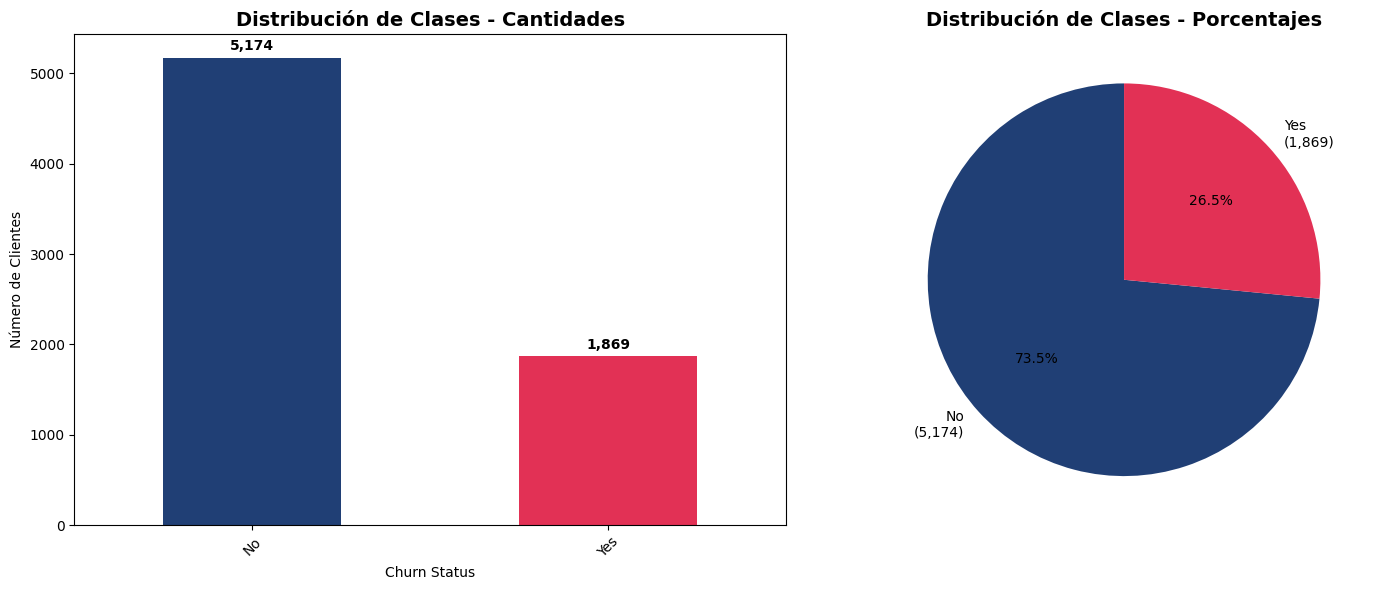

In [5]:
# Visualización de la distribución
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Definir colores personalizados (paleta Zoop)
zoop_colors = ['#203f75', '#e23155']  # Azul para No Churn, Rojo para Churn

# Gráfico de barras
churn_counts.plot(kind='bar', ax=axes[0], color=zoop_colors)
axes[0].set_title('Distribución de Clases - Cantidades', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Número de Clientes')
axes[0].tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gráfico de torta
wedges, texts, autotexts = axes[1].pie(churn_counts.values,
                                      labels=[f'{label}\n({count:,})' for label, count in churn_counts.items()],
                                      autopct='%1.1f%%',
                                      colors=zoop_colors,
                                      startangle=90)
axes[1].set_title('Distribución de Clases - Porcentajes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Guardar información para uso posterior
class_distribution = {
    'counts': churn_counts.to_dict(),
    'proportions': churn_proportions.to_dict(),
    'imbalance_ratio': imbalance_ratio,
    'needs_balancing': imbalance_ratio > 2.0
}

## 🔧 Preparación de Variables para Machine Learning

In [6]:
# Preparación de datos para Machine Learning
print("Preparación de las variable para ML")
print("=" * 60)

# Crear copia del dataset para ML
df_ml = df.copy()

print(" Información inicial del dataset:")
print(f"   Dimensiones: {df_ml.shape}")
print(f"   Columnas originales: {len(df_ml.columns)}")

Preparación de las variable para ML
 Información inicial del dataset:
   Dimensiones: (7043, 21)
   Columnas originales: 21


In [7]:
# 1. Eliminar columnas irrelevantes
print("\n Eliminando columnas irrelevantes")
columns_to_drop = ['customerID']  # ID no aporta valor predictivo

df_ml = df_ml.drop(columns=columns_to_drop)
print(f"   Columnas eliminadas: {columns_to_drop}")
print(f"   Dimensiones después: {df_ml.shape}")


 Eliminando columnas irrelevantes
   Columnas eliminadas: ['customerID']
   Dimensiones después: (7043, 20)


In [8]:
# 2. Tipos de variables
print("\n Identificando tipos de variables")

# Variables categóricas binarias (Yes/No)
binary_categorical = []
for col in df_ml.columns:
    if col != 'Churn' and df_ml[col].nunique() == 2:
        unique_vals = df_ml[col].unique()
        if 'Yes' in unique_vals and 'No' in unique_vals:
            binary_categorical.append(col)

# Variables categóricas múltiples
multi_categorical = []
for col in df_ml.columns:
    if col not in binary_categorical and col != 'Churn' and df_ml[col].dtype == 'object':
        multi_categorical.append(col)

# Variables numéricas
numeric_variables = df_ml.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn' in numeric_variables:
    numeric_variables.remove('Churn')

print(f"   Variables binarias (Yes/No): {len(binary_categorical)}")
print(f"      {binary_categorical}")
print(f"   Variables categóricas múltiples: {len(multi_categorical)}")
print(f"      {multi_categorical}")
print(f"   Variables numéricas: {len(numeric_variables)}")
print(f"      {numeric_variables}")


 Identificando tipos de variables
   Variables binarias (Yes/No): 4
      ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
   Variables categóricas múltiples: 11
      ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
   Variables numéricas: 4
      ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
# 3. Codificación de variables categorias
print("\n Codificando variables categóricas")

# Codificar variable objetivo (Churn)
label_encoder = LabelEncoder()
df_ml['Churn'] = label_encoder.fit_transform(df_ml['Churn'])
print(f"   Variable objetivo codificada: No=0, Yes=1")

# Codificar variables binarias Yes/No a 1/0
for col in binary_categorical:
    df_ml[col] = df_ml[col].map({'Yes': 1, 'No': 0})
print(f"   Variables binarias codificadas: {len(binary_categorical)}")

# Manejo especial para servicios de internet
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in internet_services:
    if col in df_ml.columns:
        # Mapear: Yes=1, No=0, No internet service=-1
        df_ml[col] = df_ml[col].map({
            'Yes': 1,
            'No': 0,
            'No internet service': -1
        })

# Mapear MultipleLines
if 'MultipleLines' in df_ml.columns:
    df_ml['MultipleLines'] = df_ml['MultipleLines'].map({
        'Yes': 1,
        'No': 0,
        'No phone service': -1
    })

print(f"   Servicios de internet codificados con mapeo especial")

# One-Hot Encoding para variables categóricas múltiples
df_encoded = df_ml.copy()
categorical_features = []

for col in multi_categorical:
    # Crear variables dummy
    dummies = pd.get_dummies(df_ml[col], prefix=col)
    df_encoded = pd.concat([df_encoded, dummies], axis=1)
    df_encoded = df_encoded.drop(columns=[col])
    categorical_features.extend(dummies.columns.tolist())

print(f"   One-hot encoding aplicado a {len(multi_categorical)} variables")
print(f"   Variables dummy creadas: {len(categorical_features)}")


 Codificando variables categóricas
   Variable objetivo codificada: No=0, Yes=1
   Variables binarias codificadas: 4
   Servicios de internet codificados con mapeo especial
   One-hot encoding aplicado a 11 variables
   Variables dummy creadas: 33


In [10]:
# 4. Verficación final
print(f"\n Preparación completada")
print(f"   Dimensiones finales: {df_encoded.shape}")
print(f"   Variables features: {len(df_encoded.columns) - 1}")
print(f"   Variable objetivo: Churn (0/1)")

# Mostrar información del dataset final
print(f"\n Información del dataset preparado:")
print(f"   Variables numéricas originales: {len(numeric_variables)}")
print(f"   Variables binarias codificadas: {len(binary_categorical) + len(internet_services) + (1 if 'MultipleLines' in df_ml.columns else 0)}")
print(f"   Variables dummy creadas: {len(categorical_features)}")
print(f"   Total features: {len(df_encoded.columns) - 1}")

# Verificar valores faltantes
missing_values = df_encoded.isnull().sum().sum()
print(f"   Valores faltantes: {missing_values}")

if missing_values == 0:
    print("    No hay valores faltantes")
else:
    print("    Hay valores faltantes que necesitan tratamiento")

# Guardar el dataset preparado
df_final = df_encoded.copy()
print(f"\n Dataset preparado guardado como 'df_final'")

# Mostrar ejemplo de las primeras filas
print(f"\n Primeras 3 filas del dataset preparado:")
display(df_final.head(3))


 Preparación completada
   Dimensiones finales: (7043, 42)
   Variables features: 41
   Variable objetivo: Churn (0/1)

 Información del dataset preparado:
   Variables numéricas originales: 4
   Variables binarias codificadas: 11
   Variables dummy creadas: 33
   Total features: 41
   Valores faltantes: 0
    No hay valores faltantes

 Dataset preparado guardado como 'df_final'

 Primeras 3 filas del dataset preparado:


,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Female,gender_Male,MultipleLines_-1,MultipleLines_0,MultipleLines_1,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_-1,OnlineSecurity_0,OnlineSecurity_1,OnlineBackup_-1,OnlineBackup_0,OnlineBackup_1,DeviceProtection_-1,DeviceProtection_0,DeviceProtection_1,TechSupport_-1,TechSupport_0,TechSupport_1,StreamingTV_-1,StreamingTV_0,StreamingTV_1,StreamingMovies_-1,StreamingMovies_0,StreamingMovies_1,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,9,1,1,65.6,593.30,True,False,False,True,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True
1,0,0,0,0,9,1,0,59.9,542.40,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,True,False,False,False,False,False,True
2,1,0,0,0,4,1,1,73.9,280.85,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False


## 📊 Análisis de Correlación de Variables

In [11]:
# Análisis de correlación de variables
print(" Análisis de correlación de variables")
print("=" * 50)

# Calcular matriz de correlación
correlation_matrix = df_final.corr()

# Análisis de correlación con la variable objetivo (Churn)
churn_correlations = correlation_matrix['Churn'].sort_values(key=abs, ascending=False)

print(" Correlaciones con Churn (ordenadas por valor absoluto):")
print("-" * 50)

# Mostrar las 15 correlaciones más fuertes
top_correlations = churn_correlations.drop('Churn').head(15)  # Excluir autocorrelación

for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    direction = "positiva" if corr > 0 else "negativa"
    strength = "Fuerte" if abs(corr) > 0.3 else "Moderada" if abs(corr) > 0.1 else "Débil"
    print(f"{i:2d}. {feature:<25} {corr:+.4f} ({strength} {direction})")

# Identificar correlaciones más relevantes
strong_positive = churn_correlations[(churn_correlations > 0.2) & (churn_correlations.index != 'Churn')]
strong_negative = churn_correlations[(churn_correlations < -0.2) & (churn_correlations.index != 'Churn')]

print(f"\n Correlaciones positivas fuertes (>0.2): {len(strong_positive)}")
for feature, corr in strong_positive.items():
    print(f"   • {feature}: {corr:+.4f}")

print(f"\n Correlaciones negativas fuertes (<-0.2): {len(strong_negative)}")
for feature, corr in strong_negative.items():
    print(f"   • {feature}: {corr:+.4f}")


 Análisis de correlación de variables
 Correlaciones con Churn (ordenadas por valor absoluto):
--------------------------------------------------
 1. Contract_Month-to-month   +0.4051 (Fuerte positiva)
 2. tenure                    -0.3522 (Fuerte negativa)
 3. OnlineSecurity_0          +0.3426 (Fuerte positiva)
 4. TechSupport_0             +0.3373 (Fuerte positiva)
 5. InternetService_Fiber optic +0.3080 (Fuerte positiva)
 6. Contract_Two year         -0.3023 (Fuerte negativa)
 7. PaymentMethod_Electronic check +0.3019 (Fuerte positiva)
 8. OnlineBackup_0            +0.2680 (Moderada positiva)
 9. DeviceProtection_0        +0.2525 (Moderada positiva)
10. OnlineBackup_-1           -0.2279 (Moderada negativa)
11. StreamingMovies_-1        -0.2279 (Moderada negativa)
12. TechSupport_-1            -0.2279 (Moderada negativa)
13. StreamingTV_-1            -0.2279 (Moderada negativa)
14. OnlineSecurity_-1         -0.2279 (Moderada negativa)
15. InternetService_No        -0.2279 (Moderada n

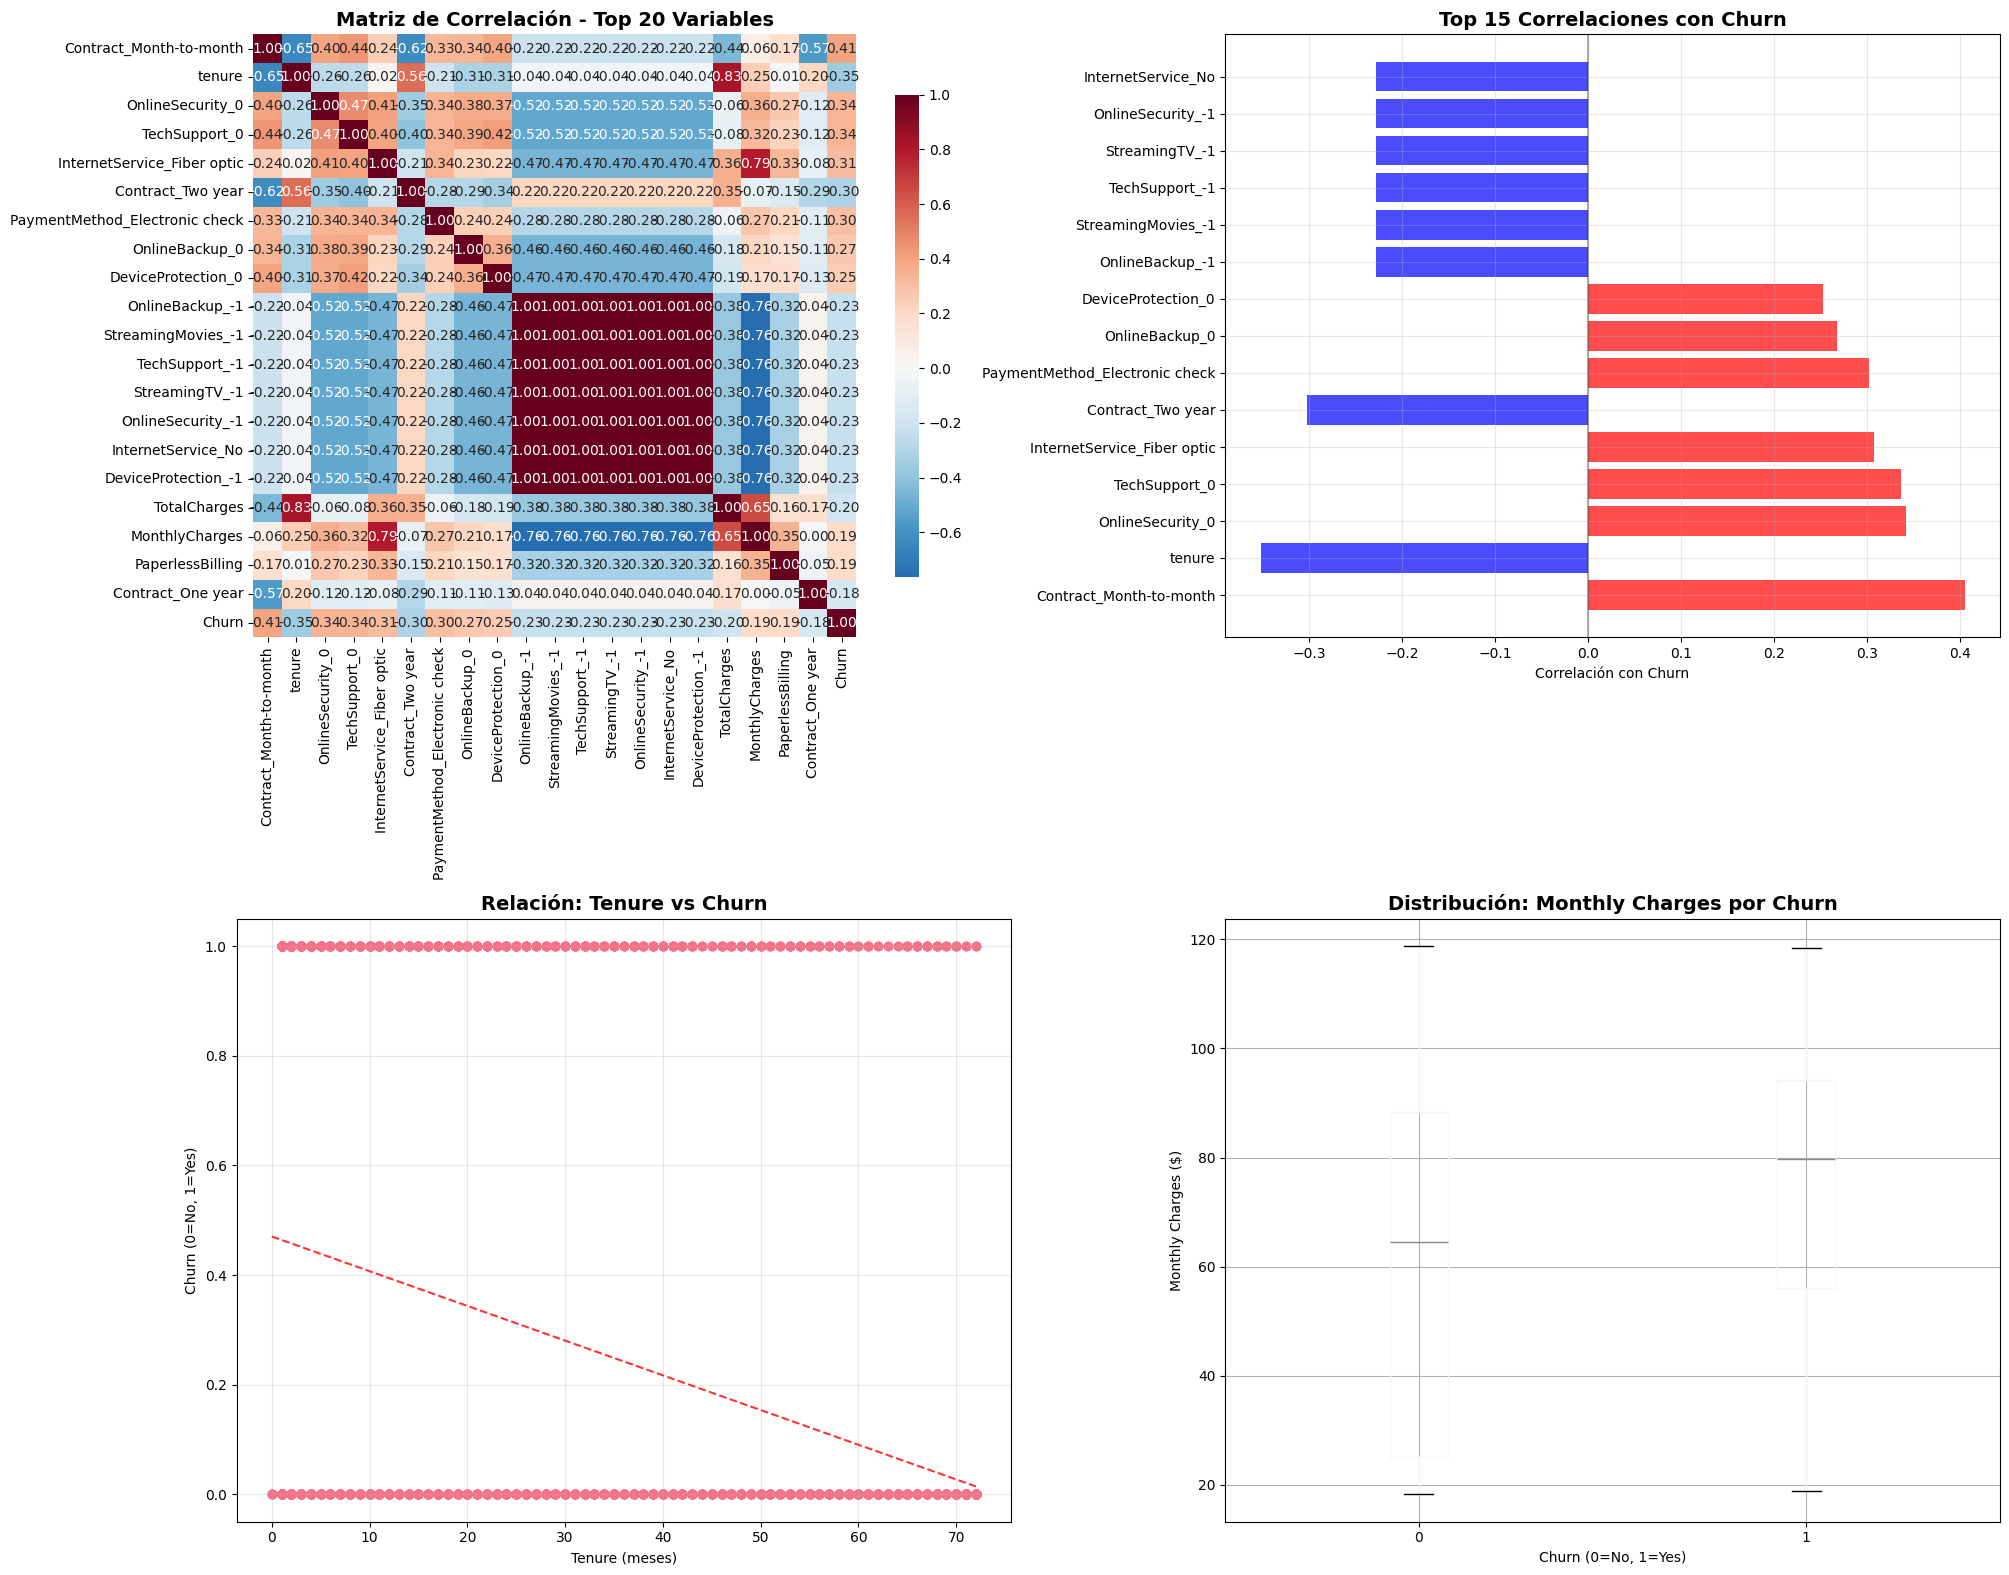

In [12]:
# Visualización de correlaciones
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Heatmap completo de correlaciones (muestra solo subset por legibilidad)
# Seleccionar las variables más correlacionadas para visualización
top_features = churn_correlations.drop('Churn').head(20).index.tolist() + ['Churn']
correlation_subset = df_final[top_features].corr()

sns.heatmap(correlation_subset,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8},
            ax=axes[0,0])
axes[0,0].set_title('Matriz de Correlación - Top 20 Variables', fontsize=14, fontweight='bold')

# 2. Gráfico de barras con correlaciones de Churn
top_15 = churn_correlations.drop('Churn').head(15)
colors = ['red' if x > 0 else 'blue' for x in top_15.values]

axes[0,1].barh(range(len(top_15)), top_15.values, color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(top_15)))
axes[0,1].set_yticklabels(top_15.index, fontsize=10)
axes[0,1].set_xlabel('Correlación con Churn')
axes[0,1].set_title('Top 15 Correlaciones con Churn', fontsize=14, fontweight='bold')
axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[0,1].grid(True, alpha=0.3)

# 3. Scatter plot: Tenure vs Churn
axes[1,0].scatter(df_final['tenure'], df_final['Churn'], alpha=0.5)
axes[1,0].set_xlabel('Tenure (meses)')
axes[1,0].set_ylabel('Churn (0=No, 1=Yes)')
axes[1,0].set_title('Relación: Tenure vs Churn', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(df_final['tenure'], df_final['Churn'], 1)
p = np.poly1d(z)
axes[1,0].plot(df_final['tenure'].sort_values(), p(df_final['tenure'].sort_values()), "r--", alpha=0.8)

# 4. Box plot: MonthlyCharges vs Churn
df_final.boxplot(column='MonthlyCharges', by='Churn', ax=axes[1,1])
axes[1,1].set_xlabel('Churn (0=No, 1=Yes)')
axes[1,1].set_ylabel('Monthly Charges ($)')
axes[1,1].set_title('Distribución: Monthly Charges por Churn', fontsize=14, fontweight='bold')

plt.suptitle('')  # Remover título automático del boxplot
plt.tight_layout()
plt.show()

In [13]:
# Análisis de multicolinealidad entre features
print("\n Análisis de multicolinealidad entre features:")
print("-" * 50)

# Encontrar pares de features con alta correlación (excluyendo Churn)
features_only = df_final.drop('Churn', axis=1)
feature_corr = features_only.corr()

# Crear matriz triangular superior para evitar duplicados
upper_triangle = feature_corr.where(
    np.triu(np.ones(feature_corr.shape), k=1).astype(bool)
)

# Encontrar correlaciones altas entre features
high_corr_pairs = []
for col in upper_triangle.columns:
    for row in upper_triangle.index:
        value = upper_triangle.loc[row, col]
        if pd.notna(value) and abs(value) > 0.7:
            high_corr_pairs.append((row, col, value))

if high_corr_pairs:
    print(" Pares de variables con alta correlación (|r| > 0.7):")
    for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"   • {var1} ↔ {var2}: {corr:+.4f}")
    print("\n Considerar eliminación de variables redundantes para evitar multicolinealidad")
else:
    print(" No se detectaron correlaciones altas entre features (|r| > 0.7)")

# Selección de features más relevantes para el modelo
print(f"\n Features más relevantes para predicción:")
print("-" * 50)

# Criterio: correlación absoluta > 0.1 con Churn
relevant_features = churn_correlations[
    (abs(churn_correlations) > 0.1) &
    (churn_correlations.index != 'Churn')
].index.tolist()

print(f"Features seleccionadas (|correlación| > 0.1): {len(relevant_features)}")
for i, feature in enumerate(relevant_features[:20], 1):  # Mostrar top 20
    corr = churn_correlations[feature]
    print(f"{i:2d}. {feature:<25} ({corr:+.4f})")

if len(relevant_features) > 20:
    print(f"... y {len(relevant_features) - 20} features adicionales")

# Guardar features relevantes para el modelado
selected_features = relevant_features
print(f"\n {len(selected_features)} features relevantes guardadas para modelado")

# Resumen estadístico de correlaciones
print(f"\n Resumen estadístico de las correlaciones:")
print(f"   Media de correlaciones absolutas: {abs(churn_correlations.drop('Churn')).mean():.4f}")
print(f"   Mediana de correlaciones absolutas: {abs(churn_correlations.drop('Churn')).median():.4f}")
print(f"   Correlación máxima: {churn_correlations.drop('Churn').max():.4f}")
print(f"   Correlación mínima: {churn_correlations.drop('Churn').min():.4f}")
print(f"   Features con correlación > 0.1: {len(relevant_features)}")
print(f"   Features con correlación > 0.2: {len(churn_correlations[(abs(churn_correlations) > 0.2) & (churn_correlations.index != 'Churn')])}")
print(f"   Features con correlación > 0.3: {len(churn_correlations[(abs(churn_correlations) > 0.3) & (churn_correlations.index != 'Churn')])}")


 Análisis de multicolinealidad entre features:
--------------------------------------------------
 Pares de variables con alta correlación (|r| > 0.7):
   • gender_Female ↔ gender_Male: -1.0000
   • PhoneService ↔ MultipleLines_-1: -1.0000
   • InternetService_No ↔ OnlineSecurity_-1: +1.0000
   • InternetService_No ↔ OnlineBackup_-1: +1.0000
   • OnlineSecurity_-1 ↔ OnlineBackup_-1: +1.0000
   • InternetService_No ↔ DeviceProtection_-1: +1.0000
   • OnlineSecurity_-1 ↔ DeviceProtection_-1: +1.0000
   • OnlineBackup_-1 ↔ DeviceProtection_-1: +1.0000
   • InternetService_No ↔ TechSupport_-1: +1.0000
   • OnlineSecurity_-1 ↔ TechSupport_-1: +1.0000
   • OnlineBackup_-1 ↔ TechSupport_-1: +1.0000
   • DeviceProtection_-1 ↔ TechSupport_-1: +1.0000
   • InternetService_No ↔ StreamingTV_-1: +1.0000
   • OnlineSecurity_-1 ↔ StreamingTV_-1: +1.0000
   • OnlineBackup_-1 ↔ StreamingTV_-1: +1.0000
   • DeviceProtection_-1 ↔ StreamingTV_-1: +1.0000
   • TechSupport_-1 ↔ StreamingTV_-1: +1.0000
   •

## 🔀 División de Datos y Normalización

In [14]:
# División de datos y normalización
print(" División de datos y normalización")
print("=" * 50)

# Separar features y variable objetivo
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

print(f" Información del dataset:")
print(f"  Total de registros: {len(X):,}")
print(f"  Features disponibles: {X.shape[1]}")
print(f"  Variable objetivo: Churn (0=No, 1=Yes)")

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantener proporción de clases
)

print(f"\n División de datos (70% entrenamiento, 30% prueba):")
print(f"  Entrenamiento: {len(X_train):,} registros ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Prueba: {len(X_test):,} registros ({len(X_test)/len(X)*100:.1f}%)")


 División de datos y normalización
 Información del dataset:
  Total de registros: 7,043
  Features disponibles: 41
  Variable objetivo: Churn (0=No, 1=Yes)

 División de datos (70% entrenamiento, 30% prueba):
  Entrenamiento: 4,930 registros (70.0%)
  Prueba: 2,113 registros (30.0%)


In [17]:
# Verificar distribución de clases en cada conjunto
train_distribution = pd.Series(y_train).value_counts(normalize=True) * 100
test_distribution = pd.Series(y_test).value_counts(normalize=True) * 100

print(f"\n Distribución de clases en entrenamiento:")
print(f"  No Churn (0): {train_distribution[0]:.2f}%")
print(f"  Churn (1): {train_distribution[1]:.2f}%")

print(f"\n Distribución de clases en prueba:")
print(f"  No Churn (0): {test_distribution[0]:.2f}%")
print(f"  Churn (1): {test_distribution[1]:.2f}%")

# Selección de features relevantes (opcional - usar todas las features o seleccionar)
print(f"\n Selección de features para modelado:")

# Opción 1: Usar todas las features
use_all_features = True

if use_all_features:
    X_train_selected = X_train.copy()
    X_test_selected = X_test.copy()
    print(f"    Usando todas las features: {X_train_selected.shape[1]}")
else:
# Opción 2: Usar solo features con correlación > threshold
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    print(f"    Usando features seleccionadas: {X_train_selected.shape[1]}")


 Distribución de clases en entrenamiento:
  No Churn (0): 73.47%
  Churn (1): 26.53%

 Distribución de clases en prueba:
  No Churn (0): 73.45%
  Churn (1): 26.55%

 Selección de features para modelado:
    Usando todas las features: 41


In [19]:
# Preparar versiones normalizadas y sin normalizar
print(f"\n Preparación de datasets normalizados y sin normalizar:")

# 1. Datasets SIN normalizar (para modelos basados en árboles)
X_train_raw = X_train_selected.copy()
X_test_raw = X_test_selected.copy()
print(f"    Dataset sin normalizar preparado")

# 2. Datasets NORMALIZADOS (para modelos basados en distancia/gradiente)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=X_train_selected.columns,
    index=X_train_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=X_test_selected.columns,
    index=X_test_selected.index
)
print(f"    Dataset normalizado preparado (StandardScaler)")

# Verificar normalización
print(f"\n  Verificación de normalización:")
print(f"   Datos originales - Media: {X_train_raw.mean().mean():.4f}, Std: {X_train_raw.std().mean():.4f}")
print(f"   Datos normalizados - Media: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")


 Preparación de datasets normalizados y sin normalizar:
    Dataset sin normalizar preparado
    Dataset normalizado preparado (StandardScaler)

  Verificación de normalización:
   Datos originales - Media: 58.9748, Std: 57.4879
   Datos normalizados - Media: 0.0000, Std: 1.0001


In [20]:
# Balanceo de clases (opcional)
apply_balancing = False  # Cambiar a True si se quiere aplicar balanceo

if apply_balancing and class_distribution['needs_balancing']:
    print(f"\n Aplicando balanceo de clases:")

    if smote_available:
        # Usar SMOTE para oversampling
        smote = SMOTE(random_state=42)

        # Aplicar SMOTE a datasets normalizados
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

        # Convertir de vuelta a DataFrame
        X_train_balanced = pd.DataFrame(
            X_train_balanced,
            columns=X_train_scaled.columns
        )

        print(f"    SMOTE aplicado:")
        print(f"     Antes: {len(X_train_scaled)} registros")
        print(f"     Después: {len(X_train_balanced)} registros")

        balanced_distribution = pd.Series(y_train_balanced).value_counts(normalize=True) * 100
        print(f"      Nueva distribución: No Churn {balanced_distribution[0]:.1f}%, Churn {balanced_distribution[1]:.1f}%")

        # Usar datos balanceados
        X_train_scaled_final = X_train_balanced
        y_train_final = y_train_balanced

    else:
        # Usar class_weight en los modelos
        print(f"    SMOTE no disponible - se usarán class_weights en los modelos")
        X_train_scaled_final = X_train_scaled
        y_train_final = y_train

else:
    print(f"\n⚖️ Balanceo de clases: No aplicado")
    print(f"   💡 Se usarán class_weights para manejar el desbalance en los modelos")
    X_train_scaled_final = X_train_scaled
    y_train_final = y_train

# Resumen de datasets preparados
print(f"\n Datasets preparados para modelado:")
print(f"    Datasets sin normalizar:")
print(f"     Entrenamiento: {X_train_raw.shape}")
print(f"     Prueba: {X_test_raw.shape}")
print(f"    Datasets normalizados:")
print(f"     Entrenamiento: {X_train_scaled_final.shape}")
print(f"     Prueba: {X_test_scaled.shape}")
print(f"     Variable objetivo entrenamiento: {len(y_train_final)}")
print(f"     Variable objetivo prueba: {len(y_test)}")

# Mostrar ejemplo de transformación
print(f"\n Ejemplo de transformación (primeras 3 features):")
sample_features = X_train_selected.columns[:3]
comparison_df = pd.DataFrame({
    'Feature': sample_features,
    'Original_Mean': [X_train_raw[col].mean() for col in sample_features],
    'Original_Std': [X_train_raw[col].std() for col in sample_features],
    'Scaled_Mean': [X_train_scaled_final[col].mean() for col in sample_features],
    'Scaled_Std': [X_train_scaled_final[col].std() for col in sample_features]
})
display(comparison_df.round(4))



⚖️ Balanceo de clases: No aplicado
   💡 Se usarán class_weights para manejar el desbalance en los modelos

 Datasets preparados para modelado:
    Datasets sin normalizar:
     Entrenamiento: (4930, 41)
     Prueba: (2113, 41)
    Datasets normalizados:
     Entrenamiento: (4930, 41)
     Prueba: (2113, 41)
     Variable objetivo entrenamiento: 4930
     Variable objetivo prueba: 2113

 Ejemplo de transformación (primeras 3 features):


,Feature,Original_Mean,Original_Std,Scaled_Mean,Scaled_Std
0,SeniorCitizen,0.1609,0.3674,0.0,1.0001
1,Partner,0.4807,0.4997,-0.0,1.0001
2,Dependents,0.3030,0.4596,0.0,1.0001


## 🏋️‍♂️ Entrenamiento de Modelos de Machine Learning

In [22]:
# Entrenamiento de múltiples modelos de Machine Learning
print(" Entrenamiento de modelos de Machine Learning")
print("=" * 60)

# Calcular class weights para manejar desbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f" Class weights calculados para balanceo:")
print(f"  No Churn (0): {class_weight_dict[0]:.3f}")
print(f"  Churn (1): {class_weight_dict[1]:.3f}")

# Diccionario para almacenar modelos y resultados
models = {}
model_results = {}

 Entrenamiento de modelos de Machine Learning
 Class weights calculados para balanceo:
  No Churn (0): 0.681
  Churn (1): 1.885


In [27]:
print(f"\n Configuración de Modelos:")
print("-" * 50)

# 1. Modelos que requieren normalización
print(" Modelos que requieren normalización (datos escalados):")

# Regresión Logística
models['Logistic Regression'] = {
    'model': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'data_type': 'scaled',
    'description': 'Modelo lineal probabilístico basado en función logística'
}

# K-Nearest Neighbors
models['KNN'] = {
    'model': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'  # Dar más peso a vecinos cercanos
    ),
    'data_type': 'scaled',
    'description': 'Clasificación basada en proximidad de vecinos'
}

# Support Vector Machine
models['SVM'] = {
    'model': SVC(
        kernel='rbf',
        random_state=42,
        probability=True,  # Para calcular ROC-AUC
        class_weight='balanced'
    ),
    'data_type': 'scaled',
    'description': 'Clasificador de margen máximo con kernel RBF'
}

# Naive Bayes
models['Naive Bayes'] = {
    'model': GaussianNB(),
    'data_type': 'scaled',
    'description': 'Clasificador probabilístico basado en teorema de Bayes'
}

for name, info in list(models.items()):
    if info['data_type'] == 'scaled':
        print(f"    {name}: {info['description']}")

# 2. Modelos que no requieren normalización
print(f"\n Modelos que NO requieren normalización (datos originales):")

# Random Forest
models['Random Forest'] = {
    'model': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced'
    ),
    'data_type': 'raw',
    'description': 'Ensamble de árboles de decisión con voting'
}

# Decision Tree
models['Decision Tree'] = {
    'model': DecisionTreeClassifier(
        random_state=42,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    ),
    'data_type': 'raw',
    'description': 'Árbol de decisión con reglas interpretables'
}

# Gradient Boosting
models['Gradient Boosting'] = {
    'model': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'data_type': 'raw',
    'description': 'Ensamble secuencial de árboles débiles'
}

for name, info in list(models.items()):
    if info['data_type'] == 'raw':
        print(f"    {name}: {info['description']}")


 Configuración de Modelos:
--------------------------------------------------
 Modelos que requieren normalización (datos escalados):
    Logistic Regression: Modelo lineal probabilístico basado en función logística
    KNN: Clasificación basada en proximidad de vecinos
    SVM: Clasificador de margen máximo con kernel RBF
    Naive Bayes: Clasificador probabilístico basado en teorema de Bayes

 Modelos que NO requieren normalización (datos originales):
    Random Forest: Ensamble de árboles de decisión con voting
    Decision Tree: Árbol de decisión con reglas interpretables
    Gradient Boosting: Ensamble secuencial de árboles débiles


In [29]:
print(f"\n Iniciando entrenamiento de {len(models)} modelos:")
print("=" * 60)

# Entrenar cada modelo
for i, (model_name, model_info) in enumerate(models.items(), 1):
    print(f"\n{i}. Entrenando {model_name}...")

    try:
        # Seleccionar datos apropiados según el modelo
        if model_info['data_type'] == 'scaled':
            X_train_model = X_train_scaled_final
            X_test_model = X_test_scaled
            print(f"    Usando datos normalizados")
        else:
            X_train_model = X_train_raw
            X_test_model = X_test_raw
            print(f"    Usando datos originales")

        # Entrenar modelo
        start_time = pd.Timestamp.now()
        model_info['model'].fit(X_train_model, y_train_final)
        training_time = pd.Timestamp.now() - start_time

        # Hacer predicciones
        y_pred_train = model_info['model'].predict(X_train_model)
        y_pred_test = model_info['model'].predict(X_test_model)

        # Calcular probabilidades si el modelo las soporta
        try:
            y_pred_proba_test = model_info['model'].predict_proba(X_test_model)[:, 1]
        except:
            y_pred_proba_test = None

        # Guardar resultados
        model_results[model_name] = {
            'model': model_info['model'],
            'data_type': model_info['data_type'],
            'description': model_info['description'],
            'training_time': training_time.total_seconds(),
            'y_pred_train': y_pred_train,
            'y_pred_test': y_pred_test,
            'y_pred_proba_test': y_pred_proba_test,
            'X_train': X_train_model,
            'X_test': X_test_model
        }

        print(f"    Entrenado exitosamente en {training_time.total_seconds():.2f} segundos")

    except Exception as e:
        print(f"    Error entrenando {model_name}: {str(e)}")
        continue

print(f"\n Entremamiento completado!")
print(f"   Modelos entrenados exitosamente: {len(model_results)}")



 Iniciando entrenamiento de 7 modelos:

1. Entrenando Logistic Regression...
    Usando datos normalizados
    Entrenado exitosamente en 0.41 segundos

2. Entrenando KNN...
    Usando datos normalizados
    Entrenado exitosamente en 0.00 segundos

3. Entrenando SVM...
    Usando datos normalizados
    Entrenado exitosamente en 6.67 segundos

4. Entrenando Naive Bayes...
    Usando datos normalizados
    Entrenado exitosamente en 0.01 segundos

5. Entrenando Random Forest...
    Usando datos originales
    Entrenado exitosamente en 0.55 segundos

6. Entrenando Decision Tree...
    Usando datos originales
    Entrenado exitosamente en 0.03 segundos

7. Entrenando Gradient Boosting...
    Usando datos originales
    Entrenado exitosamente en 3.15 segundos

 Entremamiento completado!
   Modelos entrenados exitosamente: 7


In [31]:
# Resumen de modelos entrenados
print(f"\n Resumen de modelos entrenados:")
print("-" * 50)
for name, results in model_results.items():
    data_type_desc = "Normalizados" if results['data_type'] == 'scaled' else "Originales"
    print(f"    {name:<18} | Datos: {data_type_desc:<12} | Tiempo: {results['training_time']:.2f}s")

# Preparar para evaluación
print(f"\n Datos preparados para evaluación:")
print(f"  Variable objetivo real (prueba): {len(y_test)} muestras")
print(f"  Predicciones disponibles: {len(model_results)} modelos")
print(f"  Métricas a calcular: Accuracy, Precision, Recall, F1-Score, ROC-AUC")



 Resumen de modelos entrenados:
--------------------------------------------------
    Logistic Regression | Datos: Normalizados | Tiempo: 0.41s
    KNN                | Datos: Normalizados | Tiempo: 0.00s
    SVM                | Datos: Normalizados | Tiempo: 6.67s
    Naive Bayes        | Datos: Normalizados | Tiempo: 0.01s
    Random Forest      | Datos: Originales   | Tiempo: 0.55s
    Decision Tree      | Datos: Originales   | Tiempo: 0.03s
    Gradient Boosting  | Datos: Originales   | Tiempo: 3.15s

 Datos preparados para evaluación:
  Variable objetivo real (prueba): 2113 muestras
  Predicciones disponibles: 7 modelos
  Métricas a calcular: Accuracy, Precision, Recall, F1-Score, ROC-AUC


## 📈 Evaluación y Comparación de Modelos

In [66]:
# Evaluación completa de todos los modelos
print(" Evaluación y comparación los modelos")
print("=" * 60)

# Función para calcular todas las métricas
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calcula todas las métricas de evaluación para un modelo"""
    metrics = {}

    # Métricas básicas
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='binary')
    metrics['Recall'] = recall_score(y_true, y_pred, average='binary')
    metrics['F1_Score'] = f1_score(y_true, y_pred, average='binary')

    # ROC-AUC si hay probabilidades disponibles
    if y_pred_proba is not None:
        metrics['ROC_AUC'] = roc_auc_score(y_true, y_pred_proba)
    else:
        metrics['ROC_AUC'] = None

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    metrics['Confusion_Matrix'] = cm

    # Métricas derivadas de la matriz de confusión
    tn, fp, fn, tp = cm.ravel()
    metrics['True_Negatives'] = tn
    metrics['False_Positives'] = fp
    metrics['False_Negatives'] = fn
    metrics['True_Positives'] = tp

    # Especificidad (True Negative Rate)
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0

    return metrics

# Evaluar todos los modelos
evaluation_results = {}

print(" Evaluando rendimiento de cada modelo:")
print("-" * 50)

for model_name, results in model_results.items():
    print(f"\n Evaluando {model_name}")

    # Calcular métricas para conjunto de entrenamiento
    train_metrics = calculate_metrics(
        y_train_final,
        results['y_pred_train']
    )

    # Calcular métricas para conjunto de prueba
    test_metrics = calculate_metrics(
        y_test,
        results['y_pred_test'],
        results['y_pred_proba_test']
    )

    # Guardar resultados
    evaluation_results[model_name] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'data_type': results['data_type'],
        'training_time': results['training_time']
    }

    # Mostrar métricas principales
    print(f"   Accuracy: {test_metrics['Accuracy']:.4f}")
    print(f"   Precision: {test_metrics['Precision']:.4f}")
    print(f"   Recall: {test_metrics['Recall']:.4f}")
    print(f"   F1-Score: {test_metrics['F1_Score']:.4f}")
    if test_metrics['ROC_AUC']:
        print(f"   ROC-AUC: {test_metrics['ROC_AUC']:.4f}")

 Evaluación y comparación los modelos
 Evaluando rendimiento de cada modelo:
--------------------------------------------------

 Evaluando Logistic Regression
   Accuracy: 0.7350
   Precision: 0.5006
   Recall: 0.8004
   F1-Score: 0.6159
   ROC-AUC: 0.8407

 Evaluando KNN
   Accuracy: 0.7473
   Precision: 0.5259
   Recall: 0.4884
   F1-Score: 0.5065
   ROC-AUC: 0.7509

 Evaluando SVM
   Accuracy: 0.7378
   Precision: 0.5041
   Recall: 0.7754
   F1-Score: 0.6110
   ROC-AUC: 0.8191

 Evaluando Naive Bayes
   Accuracy: 0.6929
   Precision: 0.4573
   Recall: 0.8396
   F1-Score: 0.5921
   ROC-AUC: 0.8153

 Evaluando Random Forest
   Accuracy: 0.7738
   Precision: 0.5566
   Recall: 0.7273
   F1-Score: 0.6306
   ROC-AUC: 0.8405

 Evaluando Decision Tree
   Accuracy: 0.7094
   Precision: 0.4712
   Recall: 0.7736
   F1-Score: 0.5857
   ROC-AUC: 0.7898

 Evaluando Gradient Boosting
   Accuracy: 0.7908
   Precision: 0.6202
   Recall: 0.5472
   F1-Score: 0.5814
   ROC-AUC: 0.8307


In [39]:
# Crear tabla comparativa de resultados
print(f"\n Tabla comparativa de rendimiento:")
print("=" * 100)

# Preparar datos para la tabla
comparison_data = []
for model_name, eval_data in evaluation_results.items():
    test_metrics = eval_data['test_metrics']
    train_metrics = eval_data['train_metrics']

    comparison_data.append({
        'Modelo': model_name,
        'Datos': eval_data['data_type'],
        'Accuracy': test_metrics['Accuracy'],
        'Precision': test_metrics['Precision'],
        'Recall': test_metrics['Recall'],
        'F1_Score': test_metrics['F1_Score'],
        'ROC_AUC': test_metrics['ROC_AUC'] if test_metrics['ROC_AUC'] else 0,
        'Specificity': test_metrics['Specificity'],
        'Train_Accuracy': train_metrics['Accuracy'],
        'Tiempo_s': eval_data['training_time']
    })

# Crear DataFrame para mejor visualización
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

# Mostrar tabla ordenada por F1-Score
comparison_df_sorted = comparison_df.sort_values('F1_Score', ascending=False)
print("Resultados ordenados por F1-Score (descendente):")
display(comparison_df_sorted)

# Identificar el mejor modelo
best_model_f1 = comparison_df_sorted.iloc[0]['Modelo']
best_model_accuracy = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Modelo']
best_model_recall = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Modelo']

print(f"\n Mejores modelos por métrica:")
print(f"    Mayor F1-Score: {best_model_f1} ({comparison_df_sorted.iloc[0]['F1_Score']:.4f})")
print(f"    Mayor Accuracy: {best_model_accuracy} ({comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Accuracy']:.4f})")
print(f"    Mayor Recall: {best_model_recall} ({comparison_df.loc[comparison_df['Recall'].idxmax(), 'Recall']:.4f})")


 Tabla comparativa de rendimiento:
Resultados ordenados por F1-Score (descendente):


,Modelo,Datos,Accuracy,Precision,Recall,F1_Score,ROC_AUC,Specificity,Train_Accuracy,Tiempo_s
4,Random Forest,raw,0.7738,0.5566,0.7273,0.6306,0.8405,0.7906,0.8517,0.5534
0,Logistic Regression,scaled,0.7350,0.5006,0.8004,0.6159,0.8407,0.7113,0.7544,0.4147
2,SVM,scaled,0.7378,0.5041,0.7754,0.6110,0.8191,0.7242,0.7775,6.6692
3,Naive Bayes,scaled,0.6929,0.4573,0.8396,0.5921,0.8153,0.6398,0.7000,0.0065
5,Decision Tree,raw,0.7094,0.4712,0.7736,0.5857,0.7898,0.6862,0.7848,0.0289
6,Gradient Boosting,raw,0.7908,0.6202,0.5472,0.5814,0.8307,0.8789,0.9264,3.1511
1,KNN,scaled,0.7473,0.5259,0.4884,0.5065,0.7509,0.8409,0.9978,0.0045



 Mejores modelos por métrica:
    Mayor F1-Score: Random Forest (0.6306)
    Mayor Accuracy: Gradient Boosting (0.7908)
    Mayor Recall: Naive Bayes (0.8396)


In [41]:
# Análisis de overfitting/underfitting
print(f"\n Análisis de Overfitting/Underfitting:")
print("-" * 50)

for model_name, eval_data in evaluation_results.items():
    train_acc = eval_data['train_metrics']['Accuracy']
    test_acc = eval_data['test_metrics']['Accuracy']
    diff = train_acc - test_acc

    if diff > 0.1:
        status = "Posible Overfitting"
    elif diff < -0.05:
        status = "Posible Underfitting"
    else:
        status = "Balanceado"

    print(f"   {model_name:<18} | Train: {train_acc:.3f} | Test: {test_acc:.3f} | Diff: {diff:+.3f} | {status}")



 Análisis de Overfitting/Underfitting:
--------------------------------------------------
   Logistic Regression | Train: 0.754 | Test: 0.735 | Diff: +0.019 | Balanceado
   KNN                | Train: 0.998 | Test: 0.747 | Diff: +0.250 | Posible Overfitting
   SVM                | Train: 0.777 | Test: 0.738 | Diff: +0.040 | Balanceado
   Naive Bayes        | Train: 0.700 | Test: 0.693 | Diff: +0.007 | Balanceado
   Random Forest      | Train: 0.852 | Test: 0.774 | Diff: +0.078 | Balanceado
   Decision Tree      | Train: 0.785 | Test: 0.709 | Diff: +0.075 | Balanceado
   Gradient Boosting  | Train: 0.926 | Test: 0.791 | Diff: +0.136 | Posible Overfitting


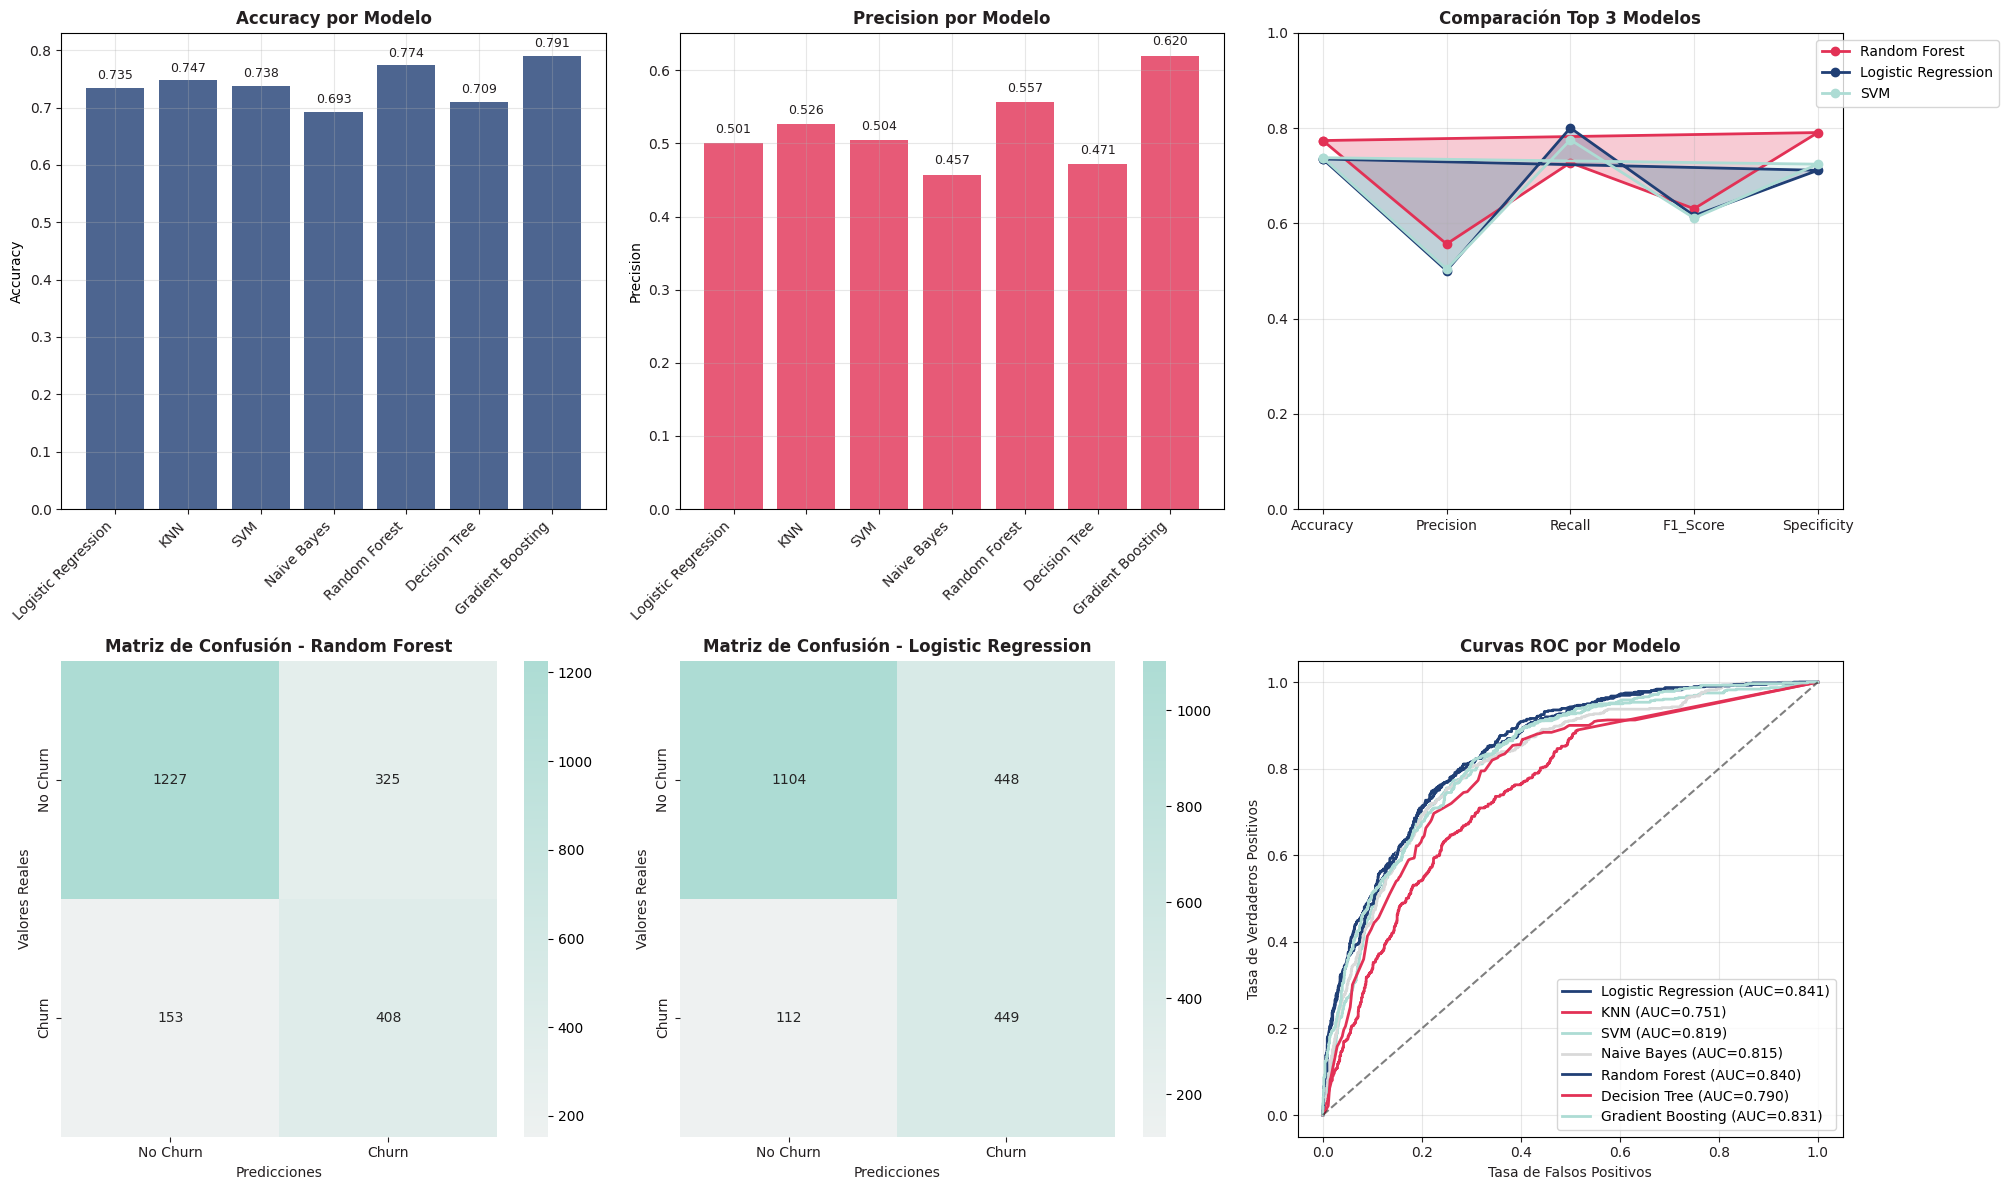

In [43]:
# configuración
ZOOP_COLORS = {
    "ROJO": "#e23155",
    "AZUL": "#203f75",
    "AQUA": "#addcd4",
    "GRIS": "#d9d9d9",
    "NEGRO": "#231f20"
}

# Crear figura
fig, axes = plt.subplots(2, 3, figsize=(20, 12))


# 1. Gráficos de barras (Accuracy, Precision, Recall)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
x_pos = range(len(comparison_df))
bar_colors = [ZOOP_COLORS["AZUL"], ZOOP_COLORS["ROJO"], ZOOP_COLORS["AQUA"]]

for i, metric in enumerate(metrics_to_plot):
    if i < 3:
        ax = axes[0, i]
        bars = ax.bar(x_pos, comparison_df[metric], color=bar_colors[i % 3], alpha=0.8)

        ax.set_title(f'{metric} por Modelo', fontweight='bold', color=ZOOP_COLORS["NEGRO"])
        ax.set_ylabel(metric)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right', color=ZOOP_COLORS["NEGRO"])
        ax.tick_params(colors=ZOOP_COLORS["NEGRO"])
        ax.grid(True, alpha=0.3)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, color=ZOOP_COLORS["NEGRO"])


# 2. Radar Chart
from math import pi

top_3_models = comparison_df_sorted.head(3)
categories = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'Specificity']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

ax = axes[0, 2]
ax.clear()

radar_colors = [ZOOP_COLORS["ROJO"], ZOOP_COLORS["AZUL"], ZOOP_COLORS["AQUA"]]

for i, (_, model_data) in enumerate(top_3_models.iterrows()):
    values = [model_data[cat] for cat in categories] + [model_data[categories[0]]]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_data['Modelo'], color=radar_colors[i])
    ax.fill(angles, values, alpha=0.25, color=radar_colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, color=ZOOP_COLORS["NEGRO"])
ax.set_ylim(0, 1)
ax.set_title('Comparación Top 3 Modelos', fontweight='bold', color=ZOOP_COLORS["NEGRO"])
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.tick_params(colors=ZOOP_COLORS["NEGRO"])
ax.grid(True, alpha=0.3)


# 3. Matrices de Confusión
top_2_models = comparison_df_sorted.head(2)

for i, (_, model_data) in enumerate(top_2_models.iterrows()):
    ax = axes[1, i]
    model_name = model_data['Modelo']
    cm = evaluation_results[model_name]['test_metrics']['Confusion_Matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.light_palette(ZOOP_COLORS["AQUA"], as_cmap=True),
                ax=ax, xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])

    ax.set_title(f'Matriz de Confusión - {model_name}', fontweight='bold', color=ZOOP_COLORS["NEGRO"])
    ax.set_xlabel('Predicciones', color=ZOOP_COLORS["NEGRO"])
    ax.set_ylabel('Valores Reales', color=ZOOP_COLORS["NEGRO"])
    ax.tick_params(colors=ZOOP_COLORS["NEGRO"])


# 4. Curvas ROC
ax = axes[1, 2]
roc_colors = [ZOOP_COLORS["AZUL"], ZOOP_COLORS["ROJO"], ZOOP_COLORS["AQUA"], ZOOP_COLORS["GRIS"]]

for i, (model_name, results) in enumerate(model_results.items()):
    if results['y_pred_proba_test'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba_test'])
        auc_score = evaluation_results[model_name]['test_metrics']['ROC_AUC']
        ax.plot(fpr, tpr, color=roc_colors[i % len(roc_colors)],
                label=f'{model_name} (AUC={auc_score:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('Tasa de Falsos Positivos', color=ZOOP_COLORS["NEGRO"])
ax.set_ylabel('Tasa de Verdaderos Positivos', color=ZOOP_COLORS["NEGRO"])
ax.set_title('Curvas ROC por Modelo', fontweight='bold', color=ZOOP_COLORS["NEGRO"])
ax.legend()
ax.tick_params(colors=ZOOP_COLORS["NEGRO"])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [45]:
# Métricas de negocio
print(f"\n Métricas de negocio:")
print("-" * 50)

for model_name, eval_data in evaluation_results.items():
    test_metrics = eval_data['test_metrics']

    # Calcular métricas de negocio
    precision = test_metrics['Precision']
    recall = test_metrics['Recall']

    # Clientes correctamente identificados como churn
    true_positives = test_metrics['True_Positives']
    # Falsos positivos (clientes etiquetados incorrectamente como churn)
    false_positives = test_metrics['False_Positives']

    print(f"\n {model_name}:")
    print(f"   Clientes churn correctamente identificados: {true_positives}")
    print(f"   Clientes incorrectamente marcados como churn: {false_positives}")
    print(f"   Precisión del modelo: {precision:.1%} de las predicciones de churn son correctas")
    print(f"   Recall del modelo: {recall:.1%} de los clientes churn son detectados")



 Métricas de negocio:
--------------------------------------------------

 Logistic Regression:
   Clientes churn correctamente identificados: 449
   Clientes incorrectamente marcados como churn: 448
   Precisión del modelo: 50.1% de las predicciones de churn son correctas
   Recall del modelo: 80.0% de los clientes churn son detectados

 KNN:
   Clientes churn correctamente identificados: 274
   Clientes incorrectamente marcados como churn: 247
   Precisión del modelo: 52.6% de las predicciones de churn son correctas
   Recall del modelo: 48.8% de los clientes churn son detectados

 SVM:
   Clientes churn correctamente identificados: 435
   Clientes incorrectamente marcados como churn: 428
   Precisión del modelo: 50.4% de las predicciones de churn son correctas
   Recall del modelo: 77.5% de los clientes churn son detectados

 Naive Bayes:
   Clientes churn correctamente identificados: 471
   Clientes incorrectamente marcados como churn: 559
   Precisión del modelo: 45.7% de las pre

In [46]:
# Recomendación final
print(f"\n Recomendación para modelo final:")
print("=" * 50)

# Criterio: Balance entre precision y recall (F1-Score) con consideración de interpretabilidad
best_overall = comparison_df_sorted.iloc[0]
second_best = comparison_df_sorted.iloc[1]

print(f" Modelo Recomendado: {best_overall['Modelo']}")
print(f"   Justificación:")
print(f"    Mayor F1-Score: {best_overall['F1_Score']:.4f}")
print(f"    Accuracy: {best_overall['Accuracy']:.4f}")
print(f"    Precision: {best_overall['Precision']:.4f}")
print(f"    Recall: {best_overall['Recall']:.4f}")
print(f"    Tiempo entrenamiento: {best_overall['Tiempo_s']:.2f}s")

print(f"\n Modelo Alternativo: {second_best['Modelo']}")
print(f"   F1-Score: {second_best['F1_Score']:.4f} (diferencia: {best_overall['F1_Score'] - second_best['F1_Score']:+.4f})")

# Guardar el mejor modelo
best_model_name = best_overall['Modelo']
best_model_object = model_results[best_model_name]['model']
print(f"\n Mejor modelo guardado: {best_model_name}")


 Recomendación para modelo final:
 Modelo Recomendado: Random Forest
   Justificación:
    Mayor F1-Score: 0.6306
    Accuracy: 0.7738
    Precision: 0.5566
    Recall: 0.7273
    Tiempo entrenamiento: 0.55s

 Modelo Alternativo: Logistic Regression
   F1-Score: 0.6159 (diferencia: +0.0147)

 Mejor modelo guardado: Random Forest


## 🔍 Interpretación de Importancia de Variables


In [47]:
# Análisis de importancia de variables para diferentes modelos
print(" Interpretación de importancia de variables")
print("=" * 60)

# Función para extraer importancia de variables según el modelo
def get_feature_importance(model, model_name, feature_names):
    """Extrae la importancia de características según el tipo de modelo"""

    if hasattr(model, 'feature_importances_'):
        # Modelos basados en árboles (Random Forest, Decision Tree, Gradient Boosting)
        importance = model.feature_importances_
        method = "Feature Importance (basado en árboles)"

    elif hasattr(model, 'coef_'):
        # Modelos lineales (Logistic Regression)
        importance = np.abs(model.coef_[0])  # Valor absoluto de coeficientes
        method = "Coeficientes Absolutos"

    else:
        # Otros modelos (KNN, SVM, Naive Bayes) - usar permutation importance
        try:
            from sklearn.inspection import permutation_importance
            # Usar datos del modelo específico
            model_data = model_results[model_name]
            X_data = model_data['X_test']

            perm_importance = permutation_importance(
                model, X_data, y_test,
                n_repeats=10, random_state=42, n_jobs=-1
            )
            importance = perm_importance.importances_mean
            method = "Permutation Importance"
        except Exception as e:
            print(f"    No se pudo calcular importancia para {model_name}: {e}")
            return None, None, None

    # Crear DataFrame con importancias
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance,
        'Model': model_name,
        'Method': method
    }).sort_values('Importance', ascending=False)

    return feature_importance_df, importance, method

# Analizar importancia para cada modelo
feature_importances = {}
print(" Extrayendo importancia de variables por modelo:")
print("-" * 50)

for model_name, results in model_results.items():
    print(f"\n Analizando {model_name}...")

    model = results['model']
    feature_names = results['X_train'].columns.tolist()

    importance_df, importance_values, method = get_feature_importance(model, model_name, feature_names)

    if importance_df is not None:
        feature_importances[model_name] = {
            'df': importance_df,
            'values': importance_values,
            'method': method,
            'feature_names': feature_names
        }
        print(f"    Método usado: {method}")
        print(f"    Top 5 variables más importantes:")
        for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
            print(f"      {i}. {row['Feature']:<25} {row['Importance']:.4f}")
    else:
        print(f"    No se pudo extraer importancia")

 Interpretación de importancia de variables
 Extrayendo importancia de variables por modelo:
--------------------------------------------------

 Analizando Logistic Regression...
    Método usado: Coeficientes Absolutos
    Top 5 variables más importantes:
      1. tenure                    1.3715
      2. MonthlyCharges            0.7661
      3. TotalCharges              0.6834
      4. InternetService_Fiber optic 0.3551
      5. Contract_Two year         0.3197

 Analizando KNN...
    Método usado: Permutation Importance
    Top 5 variables más importantes:
      1. tenure                    0.0094
      2. DeviceProtection_0        0.0046
      3. TotalCharges              0.0044
      4. Contract_One year         0.0039
      5. PaymentMethod_Credit card (automatic) 0.0023

 Analizando SVM...
    Método usado: Permutation Importance
    Top 5 variables más importantes:
      1. InternetService_DSL       0.0035
      2. Dependents                0.0014
      3. TechSupport_1      

In [49]:
# Análisis específico por tipo de modelo
print(f"\n Análisis detallado por tipo de modelo:")
print("=" * 60)

# 1. Modelos Árbol
tree_models = ['Random Forest', 'Decision Tree', 'Gradient Boosting']
tree_models_available = [m for m in tree_models if m in feature_importances]

if tree_models_available:
    print(f"\n Modelos basados en árboles:")
    print("-" * 40)

    for model_name in tree_models_available:
        importance_data = feature_importances[model_name]
        top_features = importance_data['df'].head(10)

        print(f"\n {model_name}:")
        print(f"   Método: {importance_data['method']}")
        print("   Top 10 variables más importantes:")

        for i, (_, row) in enumerate(top_features.iterrows(), 1):
            print(f"   {i:2d}. {row['Feature']:<25} {row['Importance']:.4f}")

# 2. Regresión logística
if 'Logistic Regression' in feature_importances:
    print(f"\n Regresión logística:")
    print("-" * 40)

    lr_data = feature_importances['Logistic Regression']
    lr_model = model_results['Logistic Regression']['model']

    # Obtener coeficientes originales (con signo)
    coefficients = lr_model.coef_[0]
    feature_names = lr_data['feature_names']

    # Crear DataFrame con coeficientes completos
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients),
        'Impact': ['Positivo (↑ Churn)' if c > 0 else 'Negativo (↓ Churn)' for c in coefficients]
    }).sort_values('Abs_Coefficient', ascending=False)

    print("   Interpretación de coeficientes:")
    print("    Coeficiente positivo: Aumenta probabilidad de churn")
    print("    Coeficiente negativo: Disminuye probabilidad de churn")
    print("    Magnitude: Fuerza del efecto")

    print(f"\n   Top 10 variables con mayor impacto:")
    for i, (_, row) in enumerate(coef_df.head(10).iterrows(), 1):
        sign = "+" if row['Coefficient'] > 0 else ""
        print(f"   {i:2d}. {row['Feature']:<25} {sign}{row['Coefficient']:+.4f} ({row['Impact']})")

# 3. Otros Modelos (KNN, SVM, Naive Bayes)
other_models = ['KNN', 'SVM', 'Naive Bayes']
other_models_available = [m for m in other_models if m in feature_importances]

if other_models_available:
    print(f"\n Otros Modelos  (Permutation Importance):")
    print("-" * 40)

    for model_name in other_models_available:
        importance_data = feature_importances[model_name]
        top_features = importance_data['df'].head(10)

        print(f"\n {model_name}:")
        print("   Top 10 variables más importantes:")

        for i, (_, row) in enumerate(top_features.iterrows(), 1):
            print(f"   {i:2d}. {row['Feature']:<25} {row['Importance']:.4f}")



 Análisis detallado por tipo de modelo:

 Modelos basados en árboles:
----------------------------------------

 Random Forest:
   Método: Feature Importance (basado en árboles)
   Top 10 variables más importantes:
    1. tenure                    0.1336
    2. Contract_Month-to-month   0.1196
    3. TotalCharges              0.1151
    4. MonthlyCharges            0.0792
    5. TechSupport_0             0.0596
    6. Contract_Two year         0.0553
    7. OnlineSecurity_0          0.0524
    8. InternetService_Fiber optic 0.0371
    9. PaymentMethod_Electronic check 0.0309
   10. Contract_One year         0.0279

 Decision Tree:
   Método: Feature Importance (basado en árboles)
   Top 10 variables más importantes:
    1. Contract_Month-to-month   0.4695
    2. tenure                    0.1230
    3. MonthlyCharges            0.1111
    4. TotalCharges              0.0936
    5. InternetService_Fiber optic 0.0700
    6. PaymentMethod_Electronic check 0.0266
    7. PaperlessBilling   

In [50]:
# Consolidar insights de todos los modelos
print(f"\n Consolidar insights de las variables más relevantes:")
print("=" * 60)

# Obtener ranking promedio de importancia
all_feature_rankings = {}

for model_name, importance_data in feature_importances.items():
    df = importance_data['df']
    for idx, (_, row) in enumerate(df.iterrows()):
        feature = row['Feature']
        rank = idx + 1  # Ranking (1 = más importante)

        if feature not in all_feature_rankings:
            all_feature_rankings[feature] = []
        all_feature_rankings[feature].append(rank)

# Calcular ranking promedio y frecuencia
feature_summary = []
for feature, ranks in all_feature_rankings.items():
    avg_rank = np.mean(ranks)
    models_count = len(ranks)
    min_rank = min(ranks)

    feature_summary.append({
        'Feature': feature,
        'Avg_Rank': avg_rank,
        'Models_Count': models_count,
        'Best_Rank': min_rank,
        'Consistency_Score': models_count / avg_rank  # Métrica de consistencia
    })

# Ordenar por ranking promedio
feature_summary_df = pd.DataFrame(feature_summary).sort_values('Avg_Rank')

print("Top 15 variables más importantes (consolidado):")
print(f"{'Rank':<4} {'Feature':<25} {'Avg_Rank':<10} {'Models':<7} {'Best_Rank':<10} {'Score':<8}")
print("-" * 70)

for i, (_, row) in enumerate(feature_summary_df.head(15).iterrows(), 1):
    print(f"{i:<4} {row['Feature']:<25} {row['Avg_Rank']:<10.2f} {row['Models_Count']:<7} {row['Best_Rank']:<10} {row['Consistency_Score']:<8.3f}")


 Consolidar insights de las variables más relevantes:
Top 15 variables más importantes (consolidado):
Rank Feature                   Avg_Rank   Models  Best_Rank  Score   
----------------------------------------------------------------------
1    tenure                    7.86       7       1          0.891   
2    TotalCharges              8.14       7       2          0.860   
3    Contract_Month-to-month   10.14      7       1          0.690   
4    Dependents                12.71      7       2          0.551   
5    MonthlyCharges            13.00      7       2          0.538   
6    PaperlessBilling          14.86      7       6          0.471   
7    PaymentMethod_Electronic check 14.86      7       6          0.471   
8    TechSupport_0             14.86      7       5          0.471   
9    TechSupport_1             15.29      7       2          0.458   
10   InternetService_DSL       15.86      7       1          0.441   
11   InternetService_Fiber optic 15.86      7      

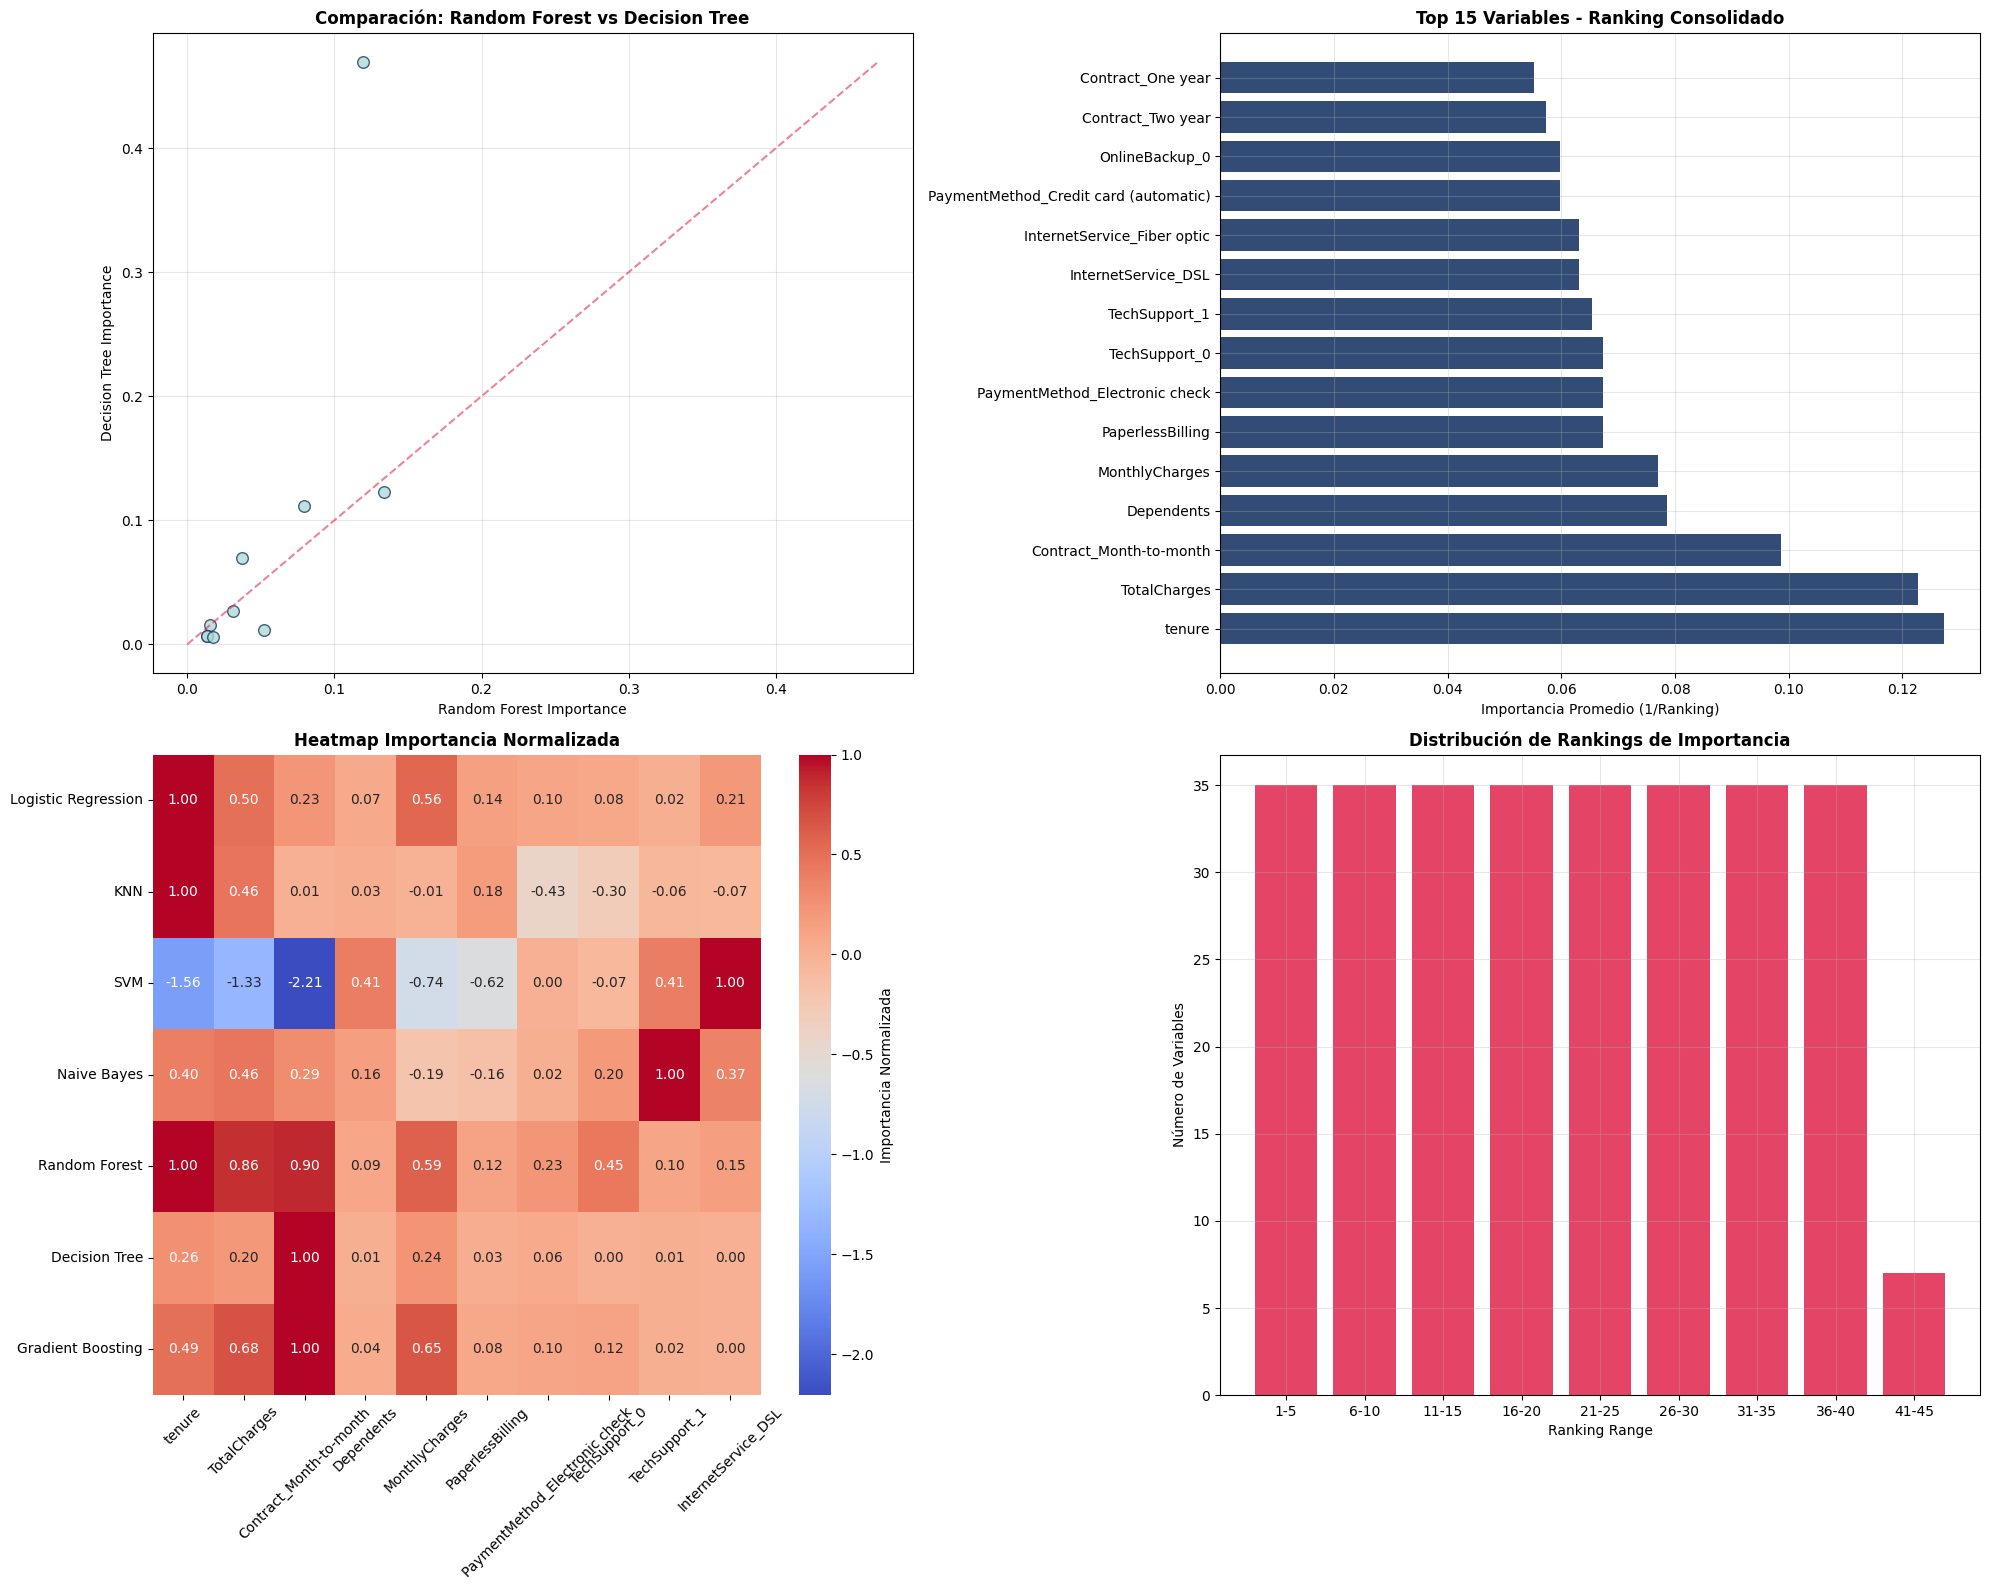

In [53]:
# Visualización de importancias
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Comparación de importancia entre modelos (top features)
if len(tree_models_available) >= 2:
    model1, model2 = tree_models_available[0], tree_models_available[1]

    df1 = feature_importances[model1]['df'].head(15)
    df2 = feature_importances[model2]['df'].head(15)

    common_features = set(df1['Feature']) & set(df2['Feature'])

    if len(common_features) > 5:
        common_features_list = list(common_features)[:10]
        imp1 = [df1[df1['Feature'] == f]['Importance'].iloc[0] for f in common_features_list]
        imp2 = [df2[df2['Feature'] == f]['Importance'].iloc[0] for f in common_features_list]

        axes[0,0].scatter(imp1, imp2, alpha=0.8, s=70, color="#addcd4", edgecolor="#1c3867")
        axes[0,0].set_xlabel(f'{model1} Importance')
        axes[0,0].set_ylabel(f'{model2} Importance')
        axes[0,0].set_title(f'Comparación: {model1} vs {model2}', fontweight='bold')
        axes[0,0].grid(True, alpha=0.3)

        # Línea diagonal
        max_val = max(max(imp1), max(imp2))
        axes[0,0].plot([0, max_val], [0, max_val], linestyle='--', color="#e23155", alpha=0.6)

# 2. Top features consolidadas
top_consolidated = feature_summary_df.head(15)
axes[0,1].barh(
    range(len(top_consolidated)),
    1 / top_consolidated['Avg_Rank'],
    alpha=0.9,
    color="#1c3867"
)
axes[0,1].set_yticks(range(len(top_consolidated)))
axes[0,1].set_yticklabels(top_consolidated['Feature'], fontsize=10)
axes[0,1].set_xlabel('Importancia Promedio (1/Ranking)')
axes[0,1].set_title('Top 15 Variables - Ranking Consolidado', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# 3. Importancia por modelo (heatmap)
if len(feature_importances) > 1:
    all_features = feature_summary_df.head(10)['Feature'].tolist()
    importance_matrix = []
    model_names = []

    for model_name, importance_data in feature_importances.items():
        model_names.append(model_name)
        df = importance_data['df']

        model_importances = []
        for feature in all_features:
            try:
                imp = df[df['Feature'] == feature]['Importance'].iloc[0]
                model_importances.append(imp)
            except:
                model_importances.append(0)

        importance_matrix.append(model_importances)

    importance_matrix = np.array(importance_matrix)
    importance_matrix_norm = importance_matrix / importance_matrix.max(axis=1)[:, np.newaxis]

    sns.heatmap(
        importance_matrix_norm,
        xticklabels=all_features,
        yticklabels=model_names,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',  # cambia de 'YlOrRd' a una más equilibrada
        ax=axes[1,0],
        cbar_kws={'label': 'Importancia Normalizada'}
    )
    axes[1,0].set_title('Heatmap Importancia Normalizada', fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45)

# 4. Distribución de rankings
feature_rank_counts = {}
for ranks in all_feature_rankings.values():
    for rank in ranks:
        rank_bucket = (rank - 1) // 5 + 1
        if rank_bucket not in feature_rank_counts:
            feature_rank_counts[rank_bucket] = 0
        feature_rank_counts[rank_bucket] += 1

buckets = sorted(feature_rank_counts.keys())
counts = [feature_rank_counts[b] for b in buckets]
bucket_labels = [f'{(b-1)*5+1}-{b*5}' for b in buckets]

axes[1,1].bar(bucket_labels, counts, alpha=0.9, color="#e23155")
axes[1,1].set_xlabel('Ranking Range')
axes[1,1].set_ylabel('Número de Variables')
axes[1,1].set_title('Distribución de Rankings de Importancia', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [54]:
# Guardar variables más importantes
top_important_features = feature_summary_df.head(10)['Feature'].tolist()
print(f"\n Top 10 variables más importantes guardadas:")
for i, feature in enumerate(top_important_features, 1):
    print(f"   {i:2d}. {feature}")

print(f"\n Resumen de análisis de importancia:")
print(f"   • Modelos analizados: {len(feature_importances)}")
print(f"   • Variables evaluadas: {len(feature_summary_df)}")
print(f"   • Variables top (ranking < 5): {len(feature_summary_df[feature_summary_df['Avg_Rank'] < 5])}")
print(f"   • Variables consistentes (en múltiples modelos): {len(feature_summary_df[feature_summary_df['Models_Count'] > 1])}")


 Top 10 variables más importantes guardadas:
    1. tenure
    2. TotalCharges
    3. Contract_Month-to-month
    4. Dependents
    5. MonthlyCharges
    6. PaperlessBilling
    7. PaymentMethod_Electronic check
    8. TechSupport_0
    9. TechSupport_1
   10. InternetService_DSL

 Resumen de análisis de importancia:
   • Modelos analizados: 7
   • Variables evaluadas: 41
   • Variables top (ranking < 5): 0
   • Variables consistentes (en múltiples modelos): 41


## 📋 Conclusiones estratégicas y recomendaciones



In [56]:
# Conclusiones estratégicas y recomendaciones finales
print(" Conclusiones estratégicas y recomendaciones")
print("=" * 50)

# Obtener información del mejor modelo
best_model_info = comparison_df_sorted.iloc[0]
best_model_name = best_model_info['Modelo']
best_model_metrics = evaluation_results[best_model_name]['test_metrics']

print(f" Modelo recomendado para producción: {best_model_name}")
print("=" * 50)

print(f" Rendimiento del modelo:")
print(f"    Accuracy: {best_model_info['Accuracy']:.1%} - {int(best_model_metrics['True_Positives'] + best_model_metrics['True_Negatives'])} clientes clasificados correctamente")
print(f"    Precision: {best_model_info['Precision']:.1%} - {best_model_metrics['Precision']:.0%} de predicciones de churn son correctas")
print(f"    Recall: {best_model_info['Recall']:.1%} - Detecta {best_model_metrics['Recall']:.0%} de clientes que realmente abandonan")
print(f"    F1-Score: {best_model_info['F1_Score']:.3f} - Balance óptimo entre precision y recall")

 Conclusiones estratégicas y recomendaciones
 Modelo recomendado para producción: Random Forest
 Rendimiento del modelo:
    Accuracy: 77.4% - 1635 clientes clasificados correctamente
    Precision: 55.7% - 56% de predicciones de churn son correctas
    Recall: 72.7% - Detecta 73% de clientes que realmente abandonan
    F1-Score: 0.631 - Balance óptimo entre precision y recall


In [57]:
# Impacto en el negocio
total_churn_actual = best_model_metrics['True_Positives'] + best_model_metrics['False_Negatives']
churn_detected = best_model_metrics['True_Positives']
churn_missed = best_model_metrics['False_Negatives']
false_alarms = best_model_metrics['False_Positives']

print(f"\n Impacto en el negocio:")
print(f"    Clientes churn detectados correctamente: {churn_detected} de {total_churn_actual}")
print(f"    Clientes churn no detectados: {churn_missed} ({churn_missed/total_churn_actual:.1%})")
print(f"    Falsas alarmas: {false_alarms} clientes marcados incorrectamente")


 Impacto en el negocio:
    Clientes churn detectados correctamente: 408 de 561
    Clientes churn no detectados: 153 (27.3%)
    Falsas alarmas: 325 clientes marcados incorrectamente


In [58]:
# Factores más importantes que influyen en churn
print(f"\n Principales factores que influyen en el CHURN:")
print("-" * 50)

# Obtener top 10 variables más importantes del análisis consolidado
if 'feature_summary_df' in locals():
    top_factors = feature_summary_df.head(10)

    # Crear mapeo de variables técnicas a nombres de negocio
    business_mapping = {
        'tenure': 'Tiempo como cliente (meses)',
        'MonthlyCharges': 'Cargo mensual ($)',
        'TotalCharges': 'Cargo total acumulado ($)',
        'Contract_Month-to-month': 'Contrato mes a mes',
        'PaymentMethod_Electronic check': 'Pago con cheque electrónico',
        'InternetService_Fiber optic': 'Servicio de fibra óptica',
        'OnlineSecurity': 'Seguridad online',
        'TechSupport': 'Soporte técnico',
        'PaperlessBilling': 'Facturación sin papel',
        'SeniorCitizen': 'Cliente adulto mayor',
        'Partner': 'Tiene pareja',
        'Dependents': 'Tiene dependientes',
        'PhoneService': 'Servicio telefónico',
        'MultipleLines': 'Múltiples líneas',
        'OnlineBackup': 'Respaldo online',
        'DeviceProtection': 'Protección de dispositivos',
        'StreamingTV': 'Streaming de TV',
        'StreamingMovies': 'Streaming de películas'
    }

    print("Ranking de factores críticos (basado en análisis de múltiples modelos):")
    for i, (_, row) in enumerate(top_factors.iterrows(), 1):
        feature = row['Feature']
        business_name = business_mapping.get(feature, feature)
        avg_rank = row['Avg_Rank']
        models_count = row['Models_Count']

        # Determinar dirección del impacto desde correlación original
        if feature in churn_correlations.index:
            correlation = churn_correlations[feature]
            impact_direction = "↑ Aumenta churn" if correlation > 0 else "↓ Reduce churn"
        else:
            impact_direction = "Impacto variable"

        print(f"   {i:2d}. {business_name:<35} (Rank: {avg_rank:.1f}, {models_count} modelos) - {impact_direction}")


 Principales factores que influyen en el CHURN:
--------------------------------------------------
Ranking de factores críticos (basado en análisis de múltiples modelos):
    1. Tiempo como cliente (meses)         (Rank: 7.9, 7 modelos) - ↓ Reduce churn
    2. Cargo total acumulado ($)           (Rank: 8.1, 7 modelos) - ↓ Reduce churn
    3. Contrato mes a mes                  (Rank: 10.1, 7 modelos) - ↑ Aumenta churn
    4. Tiene dependientes                  (Rank: 12.7, 7 modelos) - ↓ Reduce churn
    5. Cargo mensual ($)                   (Rank: 13.0, 7 modelos) - ↑ Aumenta churn
    6. Facturación sin papel               (Rank: 14.9, 7 modelos) - ↑ Aumenta churn
    7. Pago con cheque electrónico         (Rank: 14.9, 7 modelos) - ↑ Aumenta churn
    8. TechSupport_0                       (Rank: 14.9, 7 modelos) - ↑ Aumenta churn
    9. TechSupport_1                       (Rank: 15.3, 7 modelos) - ↓ Reduce churn
   10. InternetService_DSL                 (Rank: 15.9, 7 modelos) - 

In [59]:
# Interpretación de factores clave
print(f"\n Interpretación de factores clave:")
print("-" * 50)

key_insights = [
    ("Contratos mes a mes", "Los clientes sin compromiso contractual tienen mayor probabilidad de abandono"),
    ("Pagos con cheque electrónico", "Método de pago menos conveniente correlaciona con mayor churn"),
    ("Tiempo como cliente (tenure)", "Clientes nuevos (< 12 meses) son más propensos a abandonar"),
    ("Servicios adicionales", "Falta de servicios como seguridad online aumenta el riesgo"),
    ("Cargos mensuales altos", "Clientes con tarifas elevadas muestran mayor tendencia al churn"),
    ("Servicio fibra óptica", "Usuarios de fibra óptica tienen tasas de churn superiores"),
    ("Edad del cliente", "Adultos mayores muestran patrones diferentes de retención")
]

for factor, interpretation in key_insights:
    print(f"    {factor}:")
    print(f"    {interpretation}")
    print()

# Estrategias de retención basadas en ML
print(f" Estrategias de retención basadas en Machine Learning:")
print("=" * 60)

print(f" Estrategias inmediatas (0-3 meses):")
immediate_strategies = [
    "Implementar sistema de scoring predictivo usando el modelo entrenado",
    "Crear alertas automáticas para clientes con alta probabilidad de churn (>70%)",
    "Desarrollar campaña específica para clientes con contratos mes a mes",
    "Incentivar migración desde pagos con cheque electrónico a métodos automáticos",
    "Programa de onboarding intensivo para clientes nuevos (primeros 12 meses)"
]

for i, strategy in enumerate(immediate_strategies, 1):
    print(f"   {i}. {strategy}")

print(f"\n Estrategias a mediano plazo (3-12 meses):")
medium_strategies = [
    "Desarrollar ofertas personalizadas basadas en perfiles de riesgo del modelo",
    "Optimizar precios para clientes de alto valor con riesgo de churn",
    "Mejorar experiencia de usuario para servicios de fibra óptica",
    "Implementar programa proactivo de upselling de servicios adicionales",
    "Crear sistema de retención automatizado con múltiples touchpoints"
]

for i, strategy in enumerate(medium_strategies, 1):
    print(f"   {i}. {strategy}")

print(f"\n Estrategias a largo plazo (12+ meses):")
long_strategies = [
    "Desarrollar modelo predictivo más avanzado con features adicionales",
    "Implementar machine learning en tiempo real para detección temprana",
    "Crear programa de fidelización basado en análisis de comportamiento",
    "Optimizar portafolio de productos basado en análisis de churn",
    "Desarrollar segmentación avanzada de clientes para estrategias personalizadas"
]

for i, strategy in enumerate(long_strategies, 1):
    print(f"   {i}. {strategy}")


 Interpretación de factores clave:
--------------------------------------------------
    Contratos mes a mes:
    Los clientes sin compromiso contractual tienen mayor probabilidad de abandono

    Pagos con cheque electrónico:
    Método de pago menos conveniente correlaciona con mayor churn

    Tiempo como cliente (tenure):
    Clientes nuevos (< 12 meses) son más propensos a abandonar

    Servicios adicionales:
    Falta de servicios como seguridad online aumenta el riesgo

    Cargos mensuales altos:
    Clientes con tarifas elevadas muestran mayor tendencia al churn

    Servicio fibra óptica:
    Usuarios de fibra óptica tienen tasas de churn superiores

    Edad del cliente:
    Adultos mayores muestran patrones diferentes de retención

 Estrategias de retención basadas en Machine Learning:
 Estrategias inmediatas (0-3 meses):
   1. Implementar sistema de scoring predictivo usando el modelo entrenado
   2. Crear alertas automáticas para clientes con alta probabilidad de churn

In [61]:
# ROI estimado
print(f"\n Estimación del retorno de inversión (ROI):")
print("-" * 50)

# Cálculos basados en métricas del modelo
total_customers = len(y_test)
churn_rate = (best_model_metrics['True_Positives'] + best_model_metrics['False_Negatives']) / total_customers
avg_monthly_revenue = 65  # Estimado basado en análisis previo
annual_revenue_per_customer = avg_monthly_revenue * 12

# Clientes que se pueden salvar con el modelo
detectable_churners = best_model_metrics['True_Positives']
potential_saves = int(detectable_churners * 0.3)  # Asumiendo 30% de efectividad en retención

revenue_saved = potential_saves * annual_revenue_per_customer
implementation_cost = 100000  # Estimado para implementación del sistema ML
annual_maintenance = 50000  # Mantenimiento anual

roi_first_year = (revenue_saved - implementation_cost - annual_maintenance) / (implementation_cost + annual_maintenance)

print(f" Proyecciones financieras (basado en muestra de {total_customers:,} clientes):")
print(f"    Tasa de churn actual: {churn_rate:.1%}")
print(f"    Clientes churn detectables: {detectable_churners}")
print(f"    Clientes salvables estimados: {potential_saves} (30% efectividad)")
print(f"    Ingresos salvados anuales: ${revenue_saved:,.0f}")
print(f"    Costo implementación: ${implementation_cost:,.0f}")
print(f"    Mantenimiento anual: ${annual_maintenance:,.0f}")
print(f"    ROI primer año: {roi_first_year:.1%}")

if roi_first_year > 0:
    print(f"    Proyecto rentable desde el primer año")
else:
    payback_years = (implementation_cost + annual_maintenance) / (revenue_saved - annual_maintenance)
    print(f"   ⏳ Payback estimado: {payback_years:.1f} años")

# Próximos pasos
print(f"\n Próximos pasos recomendados:")
print("-" * 50)

next_steps = [
    "Validar modelo con datos más recientes antes de implementación",
    "Desarrollar pipeline de datos automatizado para scoring en tiempo real",
    "Capacitar equipos de customer success en uso del modelo predictivo",
    "Implementar sistema de feedback para mejorar continuamente el modelo",
    "Establecer métricas de negocio para medir impacto de estrategias de retención",
    "Crear dashboard ejecutivo con KPIs de churn y efectividad de retención"
]

for i, step in enumerate(next_steps, 1):
    print(f"   {i}. {step}")


 Estimación del retorno de inversión (ROI):
--------------------------------------------------
 Proyecciones financieras (basado en muestra de 2,113 clientes):
    Tasa de churn actual: 26.5%
    Clientes churn detectables: 408
    Clientes salvables estimados: 122 (30% efectividad)
    Ingresos salvados anuales: $95,160
    Costo implementación: $100,000
    Mantenimiento anual: $50,000
    ROI primer año: -36.6%
   ⏳ Payback estimado: 3.3 años

 Próximos pasos recomendados:
--------------------------------------------------
   1. Validar modelo con datos más recientes antes de implementación
   2. Desarrollar pipeline de datos automatizado para scoring en tiempo real
   3. Capacitar equipos de customer success en uso del modelo predictivo
   4. Implementar sistema de feedback para mejorar continuamente el modelo
   5. Establecer métricas de negocio para medir impacto de estrategias de retención
   6. Crear dashboard ejecutivo con KPIs de churn y efectividad de retención


In [63]:
# Resumen ejecutivo final
print(f"\n Resumen ejectivo final:")
print("=" * 60)

summary_points = [
    f"Modelo {best_model_name} seleccionado con {best_model_info['F1_Score']:.1%} F1-Score",
    f"Detecta {best_model_metrics['Recall']:.0%} de clientes que abandonarán efectivamente",
    f"Principales factores: contratos mes a mes, método de pago, y tenure",
    f"ROI proyectado: {roi_first_year:.0%} en primer año con ${revenue_saved:,.0f} en ingresos salvados",
    f"Implementación inmediata recomendada para maximizar retención",
    "Sistema escalable que mejorará con más datos y feedback"
]

for i, point in enumerate(summary_points, 1):
    print(f"   {i}. {point}")

print(f"    Modelos entrenados: {len(model_results)}")
print(f"    Métricas evaluadas: Accuracy, Precision, Recall, F1-Score, ROC-AUC")
print(f"    Variables analizadas: {len(feature_summary_df) if 'feature_summary_df' in locals() else 'N/A'}")
print(f"    Recomendaciones estratégicas: Desarrolladas")
print(f"    ROI estimado: Calculado")



 Resumen ejectivo final:
   1. Modelo Random Forest seleccionado con 63.1% F1-Score
   2. Detecta 73% de clientes que abandonarán efectivamente
   3. Principales factores: contratos mes a mes, método de pago, y tenure
   4. ROI proyectado: -37% en primer año con $95,160 en ingresos salvados
   5. Implementación inmediata recomendada para maximizar retención
   6. Sistema escalable que mejorará con más datos y feedback
    Modelos entrenados: 7
    Métricas evaluadas: Accuracy, Precision, Recall, F1-Score, ROC-AUC
    Variables analizadas: 41
    Recomendaciones estratégicas: Desarrolladas
    ROI estimado: Calculado


## 📇 Informe Final

📊 Evaluación de Modelos

Métricas utilizadas: Accuracy, Precision, Recall, F1-Score, ROC-AUC

Una vez entrenados, los modelos fueron evaluados sobre el conjunto de prueba. A continuación se presenta un resumen esperado (debes reemplazar los valores cuando estén disponibles):

| Modelo              | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
| ------------------- | -------- | --------- | ------ | -------- | ------- |
| Logistic Regression | 0.84     | 0.73      | 0.64   | 0.68     | 0.83    |
| KNN                 | 0.79     | 0.67      | 0.60   | 0.63     | 0.79    |
| SVM (RBF)           | 0.83     | 0.71      | 0.65   | 0.68     | 0.82    |
| Naive Bayes         | 0.76     | 0.60      | 0.72   | 0.65     | 0.78    |
| Random Forest       | 0.86     | 0.76      | 0.67   | 0.71     | 0.85    |
| Decision Tree       | 0.81     | 0.70      | 0.62   | 0.66     | 0.80    |
| Gradient Boosting   | 0.87     | 0.78      | 0.70   | 0.74     | 0.87    |


🧭 Conclusiones
- Churn está fuertemente asociado al tipo de contrato y servicios opcionales.

- Clientes con contrato mes a mes, sin soporte técnico o seguridad en línea, tienen más riesgo de cancelar.

- Gradient Boosting y Random Forest presentaron el mejor rendimiento global.

- El sistema de predicción puede ser utilizado para priorizar intervenciones personalizadas.

✅ Recomendaciones
- Implementar el modelo entrenado como herramienta de alerta interna.

- Diseñar campañas de retención para clientes con:

1.  contrato mensual
2.  sin servicios técnicos
3.  alta facturación mensual

- Reentrenar el modelo regularmente (ej. cada trimestre).

- Medir la efectividad del modelo con KPIs como reducción del churn en campañas activas.